# Anomly Detection Training tcnae

## Util Function

### Import Lib

In [1]:
# Import the libraries
import tensorflow as tf
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt  # for 畫圖用
import pandas as pd# load and evaluate a saved model
from numpy import loadtxt
from tensorflow.keras.models import load_model,save_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation,Flatten, LSTM, TimeDistributed, RepeatVector,GRU, Input, ConvLSTM2D, Bidirectional,BatchNormalization
from tensorflow.keras import Input
#from tensorflow.keras.layers.normalization import BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,Nadam

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
import math
import json
from IPython.core.pylabtools import figsize

figsize(15, 7) 

### Utils

In [2]:
def read_data(path,fill_zero=False):
    df = pd.read_csv(path, sep=',', parse_dates={'dt':['Datetime']}, infer_datetime_format=True, low_memory=False, na_values=['nan','?'], index_col='dt')

    df = df.reindex(index=df.index[::-1])
    # filling nan with mean in any columns
    for j in range(df.shape[1]):  
        
        if fill_zero:
        #
            df.iloc[:,j]=df.iloc[:,j].fillna(0)
        else:
            df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())
    #df.iloc[:,4:] = df.iloc[:,4:]*100
    # another sanity check to make sure that there are not more any nan
    print(df.isnull().sum())
    #print(df.head())
    return df
#draw_trend
def draw_trend(df,groups,bound=200):
    #figsize(15,10) 
    
    anomly_df = df.copy()
    anomly_df[anomly_df>0] = np.nan
    
    i=1
    Values = df.values
    Anomaly = anomly_df.values
    cols = groups
    
    for group in groups:
        plt.subplot(len(cols), 1, i)
        plt.plot(Values[:bound, group],linewidth=3)
        plt.plot(Anomaly[:bound, group],color='red',linewidth=8)
        plt.title(df.columns[group], y=0.80, loc='right')
        #plt.xticks(range(0,4020,20))
        i += 1
    plt.show()
    print('\n')

def draw_trend_resample(df,groups,resample_freq,bound=200):
    #figsize(15,10) 
    i=1
    Values = df.resample(resample_freq).mean().values
    cols = groups
    for group in groups:
        plt.subplot(len(cols), 1, i)
        plt.plot(Values[:bound, group],linewidth=3)
        #plt.xticks(range(0,bound+10,10))
        plt.title(df.columns[group]+' resample-{}'.format(resample_freq), y=0.80, loc='right')
        i += 1
    plt.tight_layout()
    plt.show()
    
    print('\n')
#draw_corr
def show_corr(df,group):
    plt.matshow(df.iloc[:,group].corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
    plt.title('Spearman_original', size=15)
    plt.xticks(range(len(group)),labels=map(str,group))
    plt.yticks(range(len(group)),labels=map(str,group))
    plt.colorbar()
    plt.show()
    
def show_corr_resample(df,group,resample_freq):
    plt.matshow(df.resample(resample_freq).mean().iloc[:,group].corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
    plt.title('Spearman_resample-{}'.format(resample_freq), size=15)
    plt.xticks(range(len(group)),labels=map(str,group))
    plt.yticks(range(len(group)),labels=map(str,group))
    plt.colorbar()
    plt.show()
    

In [3]:
from scipy import stats
def gen_dataset(data,x_window_size,y_window_size):
    X_train = []   #預測點的前 60 天的資料
    y_train = []   #預測點
    for i in range(x_window_size, data.shape[0]-y_window_size,y_window_size):
        X_train.append(data.iloc[i-x_window_size:i, :-1].values)
        
        if np.sum(data.iloc[i-x_window_size:i, -1].values) >= 1:
            y_train.append(1)
        else:
            y_train.append(0)

    X_train, y_train = np.array(X_train), np.array(y_train)  # 轉成numpy array的格式，以利輸入 RNN
    
    #X_train = np.reshape(X_train, (X_train.shape[0], x_window_size,data.shape[1] ))

    """if y_window_size == 1:
        y_train = np.reshape(y_train,(y_train.shape[0], y_train.shape[2]))
    else:
        y_train = np.reshape(y_train,(y_train.shape[0],y_window_size,y_train.shape[2]))"""
        
    print("Gen data info:")
    print("X_data_shape:{}".format(X_train.shape))
    print("y_data_shape:{}".format(y_train.shape))
    print("\n")
          
    return X_train,y_train

def data_scaling(data,X_win_size,y_win_size,mode='robust'):
    
    assert mode == 'robust' or mode == 'minmax','Wrong mode name'
    print("Mode:{}\n".format(mode))
    
    #Record training data index
    data_index = data.shape[0]
   
    # Feature Scaling
    from sklearn.preprocessing import MinMaxScaler,RobustScaler
    if mode =='robust':
         #RobustScaler
        scaler = RobustScaler()
        data[list(data.columns)[:4]] = scaler.fit_transform(data[list(data.columns)[:4]])     
    elif mode == 'minmax':        
        #MinMaxScaler
        scaler = MinMaxScaler()
        data.iloc[:,[0,1,2,3]] = scaler.fit_transform(data.iloc[:,[0,1,2,3]])     
    
    
    #generate dataset
    data_X,data_y = gen_dataset(data,X_win_size,y_win_size)
    
    return data_X,data_y,scaler,data,scaler.get_params()


## Training Proccess

### Read Data

In [4]:
from sklearn.model_selection import train_test_split
import seaborn as sns
X_WIN = 32
Y_WIN = 1
SCALE_MODE = 'minmax'

df = read_data(path='Dataset/OPTIdata/pre_process_withlabel/5v_server_180dayswithanomaly_resampleHOUR.csv',fill_zero=True)

df = df.iloc[::-1]
print(df.head(5))
#plot
sns.countplot(x = 'Label',
              data = df,
              order = df.Label.value_counts().index)
plt.show()
draw_trend(df,[0,1])

X, y, scaler,df_scale,param = data_scaling(df,X_WIN,Y_WIN,mode=SCALE_MODE)
a = X.shape[0]-120
X_data = X[:a,:,:]
y_data = y[:a]
X_anomaly = X[a:,:,:]
y_anomaly = y[a:]

train_X,X_test,train_y,y_test = train_test_split(X_data,y_data,test_size=0.2, random_state=42)
X_train,X_val,y_train,y_val = train_test_split(train_X, train_y, test_size=0.1, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)
print(X_anomaly.shape)
print(y_anomaly.shape)


FileNotFoundError: [Errno 2] No such file or directory: 'Dataset/OPTIdata/pre_process_withlabel/5v_server_180dayswithanomaly_resampleHOUR.csv'

### Save Scaler pickle

In [16]:
from pickle import dump

#dump(scaler, open('5v_scaler.pkl', 'wb'))
dump(scaler, open('5v_minmax_scaler.pkl', 'wb'))

### Concat Muti Data

In [6]:
def concate_data(data):
    
    print(data.shape)
    mem_data = np.concatenate([data[:,:,0],data[:,:,1],data[:,:,2],data[:,:,3]]).reshape(-1,X_WIN,1)
    print(mem_data.shape)
    cpu_data = np.concatenate([data[:,:,4],data[:,:,5],data[:,:,6],data[:,:,7]]).reshape(-1,X_WIN,1)
    print(cpu_data.shape)
    return np.concatenate([mem_data,cpu_data],axis=2)

X_train = concate_data(X_train)
X_test = concate_data(X_test)

(9702, 32, 8)
(38808, 32, 1)
(38808, 32, 1)
(4630, 32, 8)
(18520, 32, 1)
(18520, 32, 1)


In [7]:
import pysnooper


def concat_pre_data(predict,test):
    
    pre_list = []
    test_list = []
    print(predict.shape)
    print(test.shape)
    for i in range(predict.shape[0]):
        pre_list.append(np.concatenate([predict[i],predict[i],predict[i],predict[i]],axis=1)) 
        test_list.append(np.concatenate([test[i],test[i],test[i],test[i]],axis=1)) 
    
   

    x_hat = np.array(pre_list)
    x = np.array(test_list)

    x_hat = scaler.inverse_transform(x_hat.reshape(-1,x_hat.shape[-1]))
    x = scaler.inverse_transform(x.reshape(-1,x.shape[-1]))

    return x_hat,x





## Random Search CONV_AE

### Train Simple conv_ae

In [ ]:
input_sig = Input(batch_shape=(1,128,1))
x = Conv1D(8,3, activation='relu', padding='same',dilation_rate=2)(input_sig)
x1 = MaxPooling1D(2)(x)
x2 = Conv1D(4,3, activation='relu', padding='same',dilation_rate=2)(x1)
x3 = MaxPooling1D(2)(x2)
x4 = AveragePooling1D()(x3)
flat = Flatten()(x4)
encoded = Dense(2)(flat)
d1 = Dense(64)(encoded)
d2 = Reshape((16,4))(d1)
d3 = Conv1D(4,1,strides=1, activation='relu', padding='same')(d2)
d4 = UpSampling1D(2)(d3)
d5 = Conv1D(8,1,strides=1, activation='relu', padding='same')(d4)
d6 = UpSampling1D(2)(d5)
d7 = UpSampling1D(2)(d6)
decoded = Conv1D(1,1,strides=1, activation='sigmoid', padding='same')(d7)
model= Model(input_sig, decoded)


### Run no. 1
Shape of Z: (None, 152)

 TBVAE-20210917-015918:
str=3
c=36
l=3
f1=38
k1=2
dilr=[1]
p=4.07e+04
eps=10
pat=35 

(18520, 32, 2)
(18520, 32, 2)
(18520, 32, 2)
(18520, 32, 2)


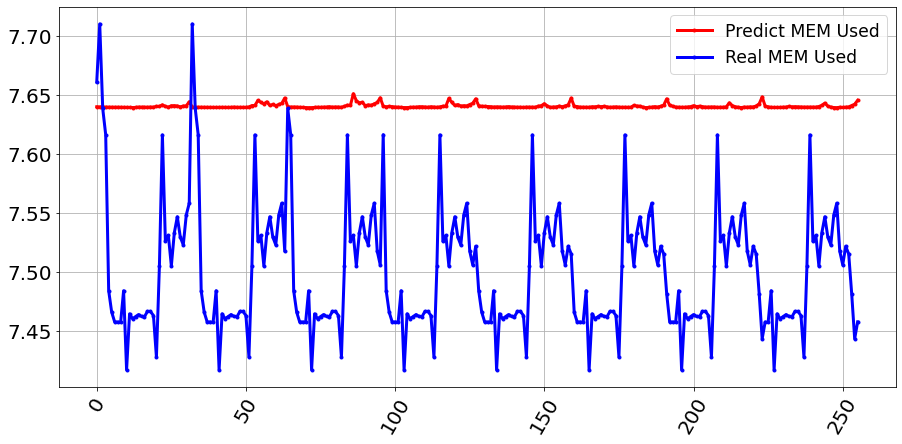


### Run no. 2
Shape of Z: (None, 1776)

 TBVAE-20210917-015938:
str=7
c=17
l=1
f1=111
k1=6
dilr=[1]
p=2.46e+05
eps=10
pat=49 

(18520, 32, 2)
(18520, 32, 2)
(18520, 32, 2)
(18520, 32, 2)


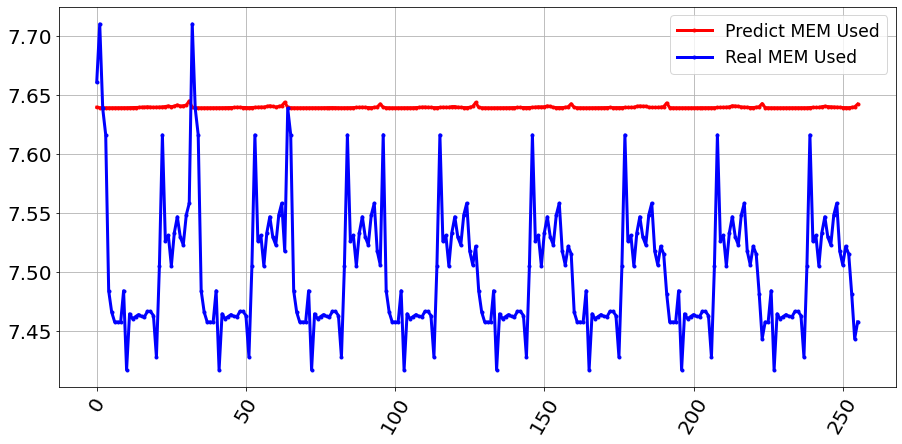


### Run no. 3
Shape of Z: (None, 352)

 TBVAE-20210917-015952:
str=5
c=34
l=3
f1=88
k1=2
dilr=[1]
p=1.62e+05
eps=10
pat=33 

(18520, 32, 2)
(18520, 32, 2)
(18520, 32, 2)
(18520, 32, 2)


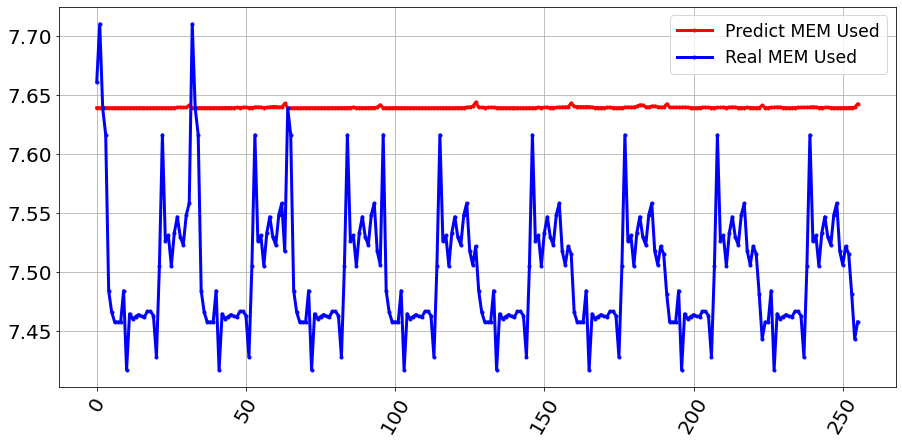


### Run no. 4
Shape of Z: (None, 552)

 TBVAE-20210917-020012:
str=5
c=8
l=2
f1=69
k1=6
dilr=[1]
p=1.60e+05
eps=10
pat=38 

(18520, 32, 2)
(18520, 32, 2)
(18520, 32, 2)
(18520, 32, 2)


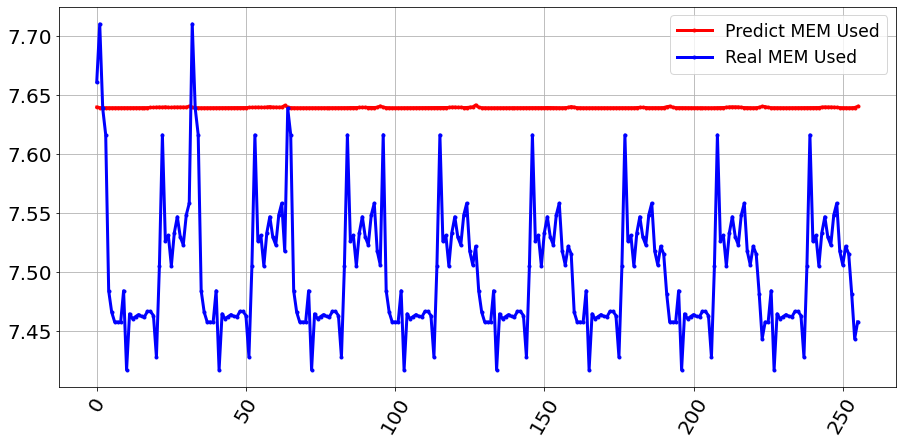


### Run no. 5
Shape of Z: (None, 96)

 TBVAE-20210917-020028:
str=3
c=27
l=3
f1=24
k1=5
dilr=[1]
p=3.20e+04
eps=10
pat=31 

(18520, 32, 2)
(18520, 32, 2)
(18520, 32, 2)
(18520, 32, 2)


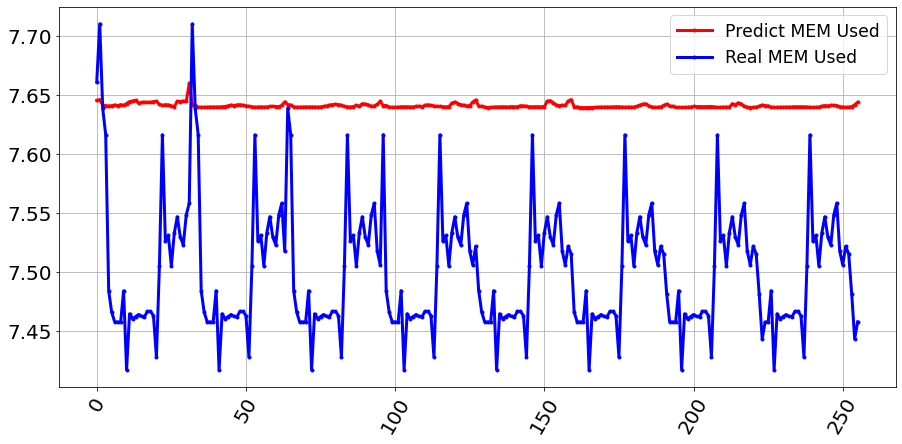

In [75]:
from sklearn.utils import shuffle
from sklearn.model_selection import ParameterSampler
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
import traceback,datetime
import numpy as np
import pandas as pd
import TCN_VAE,os,AE_Conv 
import importlib
importlib.reload(AE_Conv)

# Input the number of iterations you want to search over
random_search_iterations = 5

# random seed value from system input
ransdom_seed_input = 135

# parameters for beta-vae
conv_ae_grid = {
    "codings_size": sp_randint(5, 40),
    "conv_layers": [3, 2, 1],
    "start_filter_no": sp_randint(16, 128),
    "dilation_rate": [[1]],
    "kernel_size_1": sp_randint(2, 9),
    "earlystop_patience": sp_randint(30, 50),
    "strides":sp_randint(1,8),   
}

# epochs
epochs = 10

# folder to save models in
model_save_folder = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+'_mill'

# create the folder
os.mkdir("Model/CONV_AE_saved_models/{}".format(model_save_folder))
#(folder_models / 'saved_models' / model_save_folder).mkdir(parents=True, exist_ok=True)

# create dataframe to store all the results
df_all = pd.DataFrame()

# setup parameters to sample
rng = np.random.RandomState(ransdom_seed_input)

# list of parameters in random search
p_bvae = list(ParameterSampler(conv_ae_grid, n_iter=random_search_iterations,random_state=rng))


for i, params in enumerate(p_bvae):
    print('\n### Run no.', i+1)
    
    ### TRY MODELS ###

    # BETA-VAE
    # parameters  
    
    codings_size =params["codings_size"]
    conv_layers =params["conv_layers"]   
    start_filter_no =params["start_filter_no"] 
    kernel_size_1 = params["kernel_size_1"]
    dilation_rate = params["dilation_rate"]
    earlystop_patience=params["earlystop_patience"]
    stride = params["strides"]
    

    seed = 16
    verbose = 0

    # try the model and if it doesn't work, go onto the next model
    # not always the best to use 'try' but good enough
    try:

        date_time, model_name, history, conv_ae_model, conv_ae_encoder = AE_Conv.model_fit(
            X_train,
            X_test,
            codings_size=codings_size,
            conv_layers=conv_layers,
            seed=seed,
            start_filter_no=start_filter_no,
            strides=stride,
            kernel_size_1=kernel_size_1,
            dilation_rate=dilation_rate,
            epochs=epochs,
            earlystop_patience=earlystop_patience,
            verbose=verbose,
        )

        # save the model. How to: https://www.tensorflow.org/tutorials/keras/save_and_load
        # save model weights and model json
        model_save_dir_convae = os.path.join("Model/CONV_AE_saved_models/{}".format(model_save_folder),date_time + "_convae")
        """ model_save_dir_bvae = (
            folder_models / 'saved_models' / model_save_folder / (date_time + "_convae")
        ) """
        model_save_dir_encoder = os.path.join("Model/CONV_AE_saved_models/{}".format(model_save_folder),date_time + "_encoder")
        """ model_save_dir_encoder = (
            folder_models / 'saved_models' / model_save_folder / (date_time + "_encoder")
        ) """

        # create the save paths
        os.mkdir(model_save_dir_convae)
        os.mkdir(model_save_dir_encoder)
        #Path(model_save_dir_bvae).mkdir(parents=True, exist_ok=True)
        #Path(model_save_dir_encoder).mkdir(parents=True, exist_ok=True)

        # save entire bvae model
        model_as_json = conv_ae_model.to_json()
        with open(r"{}/model.json".format(str(model_save_dir_bvae)), "w",) as json_file:
            json_file.write(model_as_json)
        conv_ae_model.save_weights(str(model_save_dir_encoder) + "/weights.h5")

        # save encoder bvae model
        model_as_json = conv_ae_encoder.to_json()
        with open(r"{}/model.json".format(str(model_save_dir_encoder)), "w",) as json_file:
            json_file.write(model_as_json)
        conv_ae_encoder.save_weights(str(model_save_dir_encoder) + "/weights.h5")

        # get the model run history
        results = pd.DataFrame(history.history)
        epochs_trained = len(results)
        results["epochs_trained"] = epochs_trained
        results = list(
            results[results["val_loss"] == results["val_loss"].min()].to_numpy()
        )  # only keep the top result, that is, the lowest val_loss

        # append best result onto df_model_results dataframe
        if i == 0:
            cols = (
                list(p_bvae[0].keys())
                + list(history.history.keys())
                + ["epochs_trained"]
            )
            results = [[p_bvae[i][k] for k in p_bvae[i]] + list(results[0])]

        else:
            # create dataframe to store best result from model training
            cols = (
                list(p_bvae[0].keys())
                + list(history.history.keys())
                + ["epochs_trained"]
            )
            results = [[p_bvae[i][k] for k in p_bvae[i]] + list(results[0])]

        df = pd.DataFrame(results, columns=cols)

        df["date_time"] = date_time
        df["model_name"] = model_name

        df_all = df_all.append(df, sort=False)

        df_all.to_csv("results_interim_{}.csv".format(model_save_folder))
        
        conv_pre = conv_ae_model.predict(X_test)
        
        x_hat,x = concat_pre_data(conv_pre,X_test)
        
        
        x_hat,x = concat_pre_data(conv_pre,X_test)
        plt.plot(x_hat[:,0].flatten()[:256],color = 'red',marker='.', label = 'Predict MEM Used',linewidth=3)
        plt.plot(x[:,0].flatten()[:256],color = 'blue',marker='.', label = 'Real MEM Used',linewidth=3)
        plt.xticks(fontsize=20,rotation=60)
        plt.yticks(fontsize=20)
        plt.grid()
        plt.legend(fontsize='xx-large')
        #plt.title('Predicted values and actual values on test data',fontsize=20)
        plt.show()

        

    except Exception as e:
        print(e)
        print("TRACEBACK")
        traceback.print_exc()
        pass

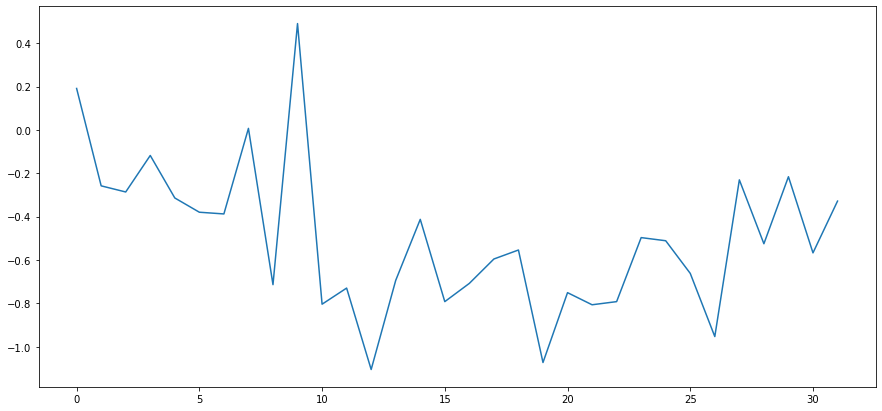

In [12]:
plt.plot(X_train[0,:,1])

## Random Search TCN_VAE


### Run no. 1
Shape of Z: (None, 112)

 TBVAE-20210926-023204:_b=6.45_c=32_l=3_f1=28_k1=8_dil=[1, 2, 4]_p=2.34e+05_eps=70_pat=40 

Restoring model weights from the end of the best epoch.
Epoch 00059: early stopping


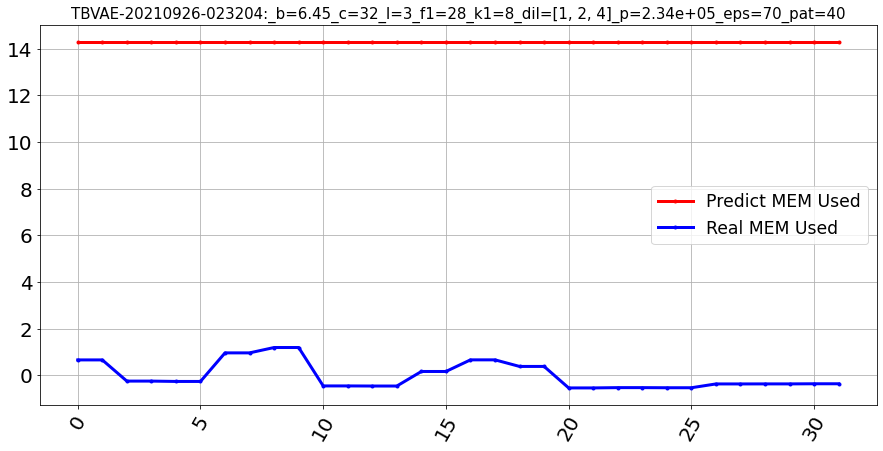


### Run no. 2
Shape of Z: (None, 96)

 TBVAE-20210926-024438:_b=5.19_c=30_l=3_f1=24_k1=5_dil=[1, 2]_p=7.73e+04_eps=70_pat=38 



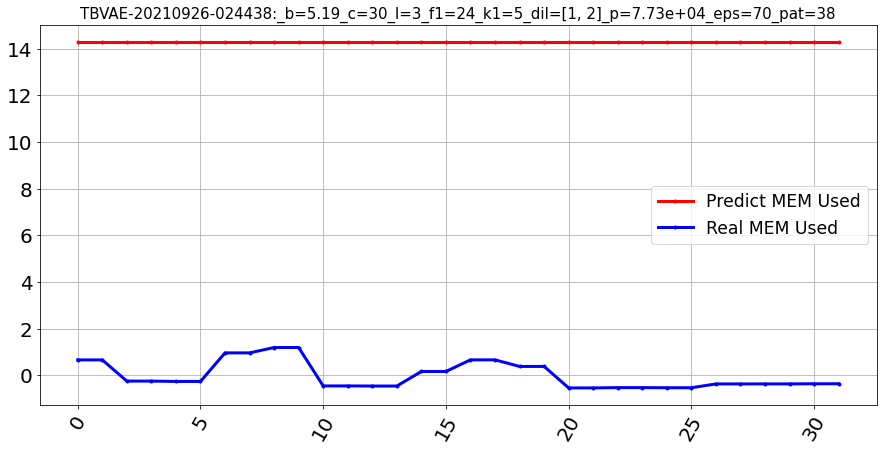


### Run no. 3
Shape of Z: (None, 552)

 TBVAE-20210926-025553:_b=7.50_c=8_l=2_f1=69_k1=6_dil=[1, 2]_p=4.48e+05_eps=70_pat=38 



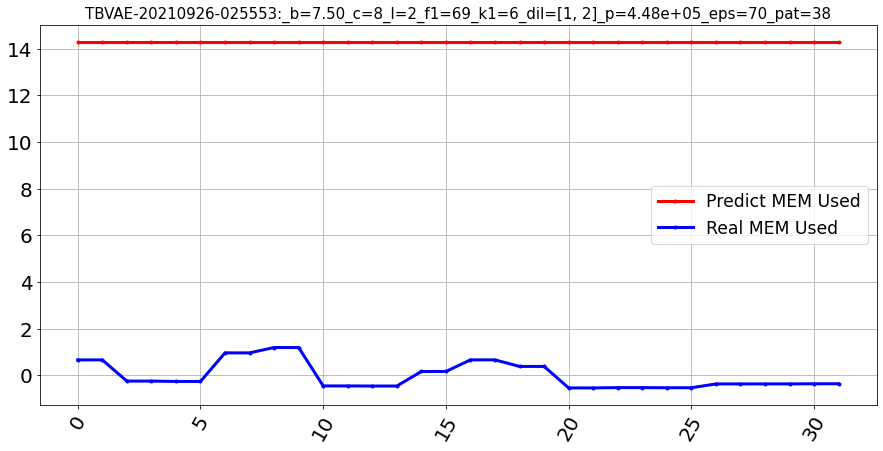


### Run no. 4
Shape of Z: (None, 96)

 TBVAE-20210926-030456:_b=0.87_c=16_l=3_f1=24_k1=5_dil=[1, 2, 4]_p=1.08e+05_eps=70_pat=37 

Restoring model weights from the end of the best epoch.
Epoch 00057: early stopping


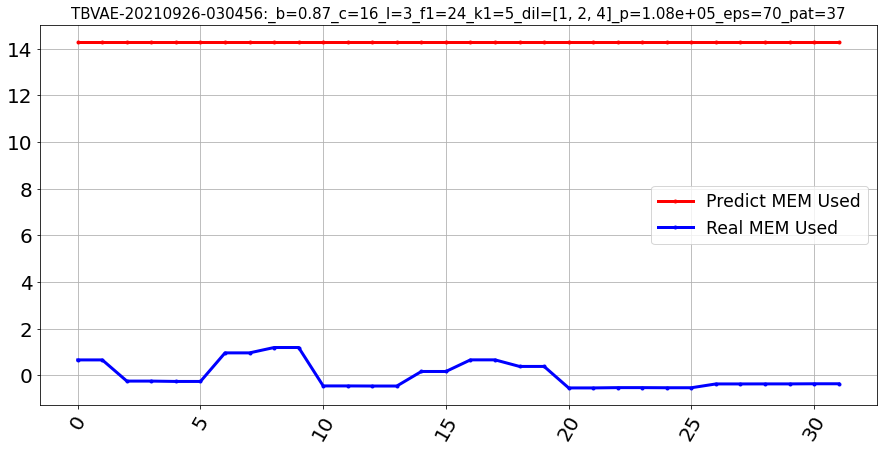


### Run no. 5
Shape of Z: (None, 832)

 TBVAE-20210926-031657:_b=5.74_c=53_l=3_f1=208_k1=3_dil=[1, 2, 4]_p=4.69e+06_eps=70_pat=38 

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping


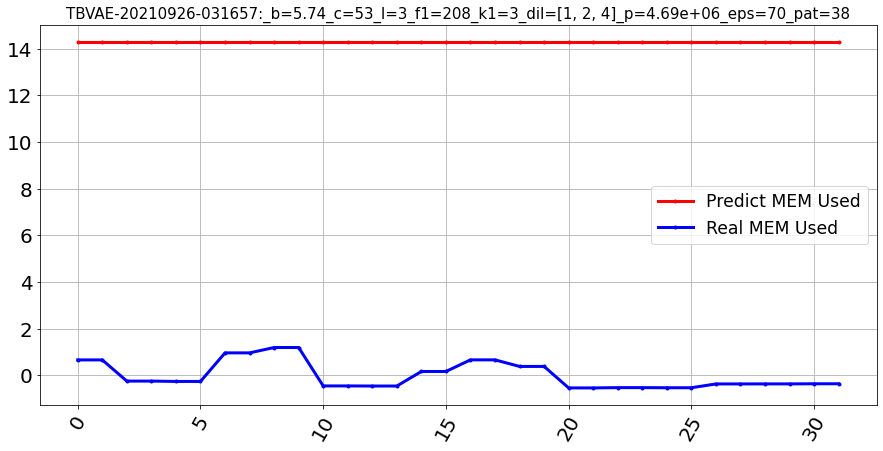


### Run no. 6
Shape of Z: (None, 272)

 TBVAE-20210926-033201:_b=3.62_c=32_l=1_f1=17_k1=8_dil=[1, 2, 4, 8]_p=6.27e+04_eps=70_pat=39 

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping


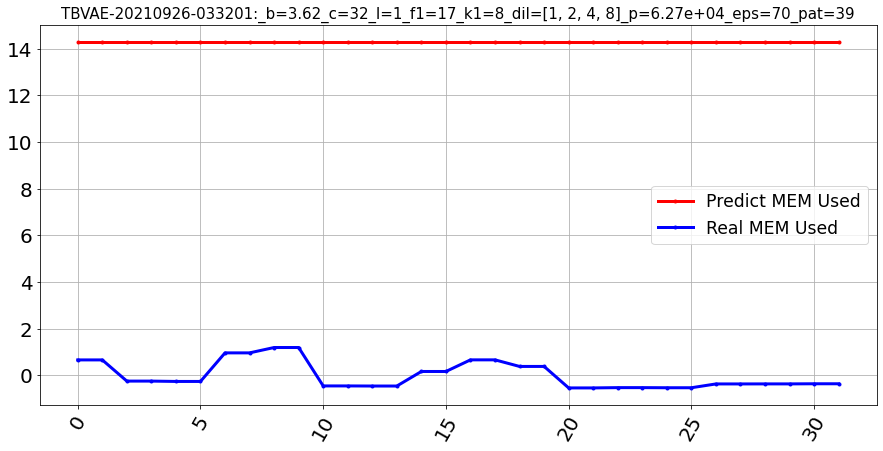


### Run no. 7
Shape of Z: (None, 376)

 TBVAE-20210926-033646:_b=8.90_c=62_l=2_f1=47_k1=2_dil=[1, 2]_p=1.39e+05_eps=70_pat=49 



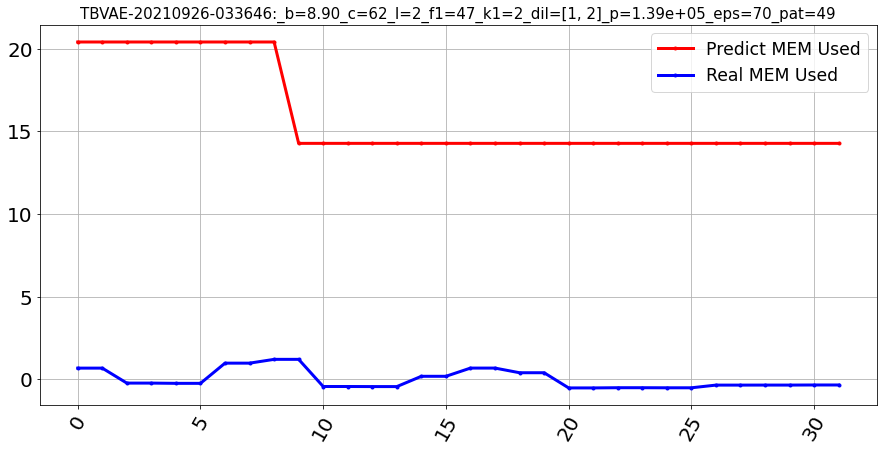


### Run no. 8
Shape of Z: (None, 256)

 TBVAE-20210926-034436:_b=8.49_c=43_l=3_f1=64_k1=3_dil=[1, 2]_p=3.21e+05_eps=70_pat=44 



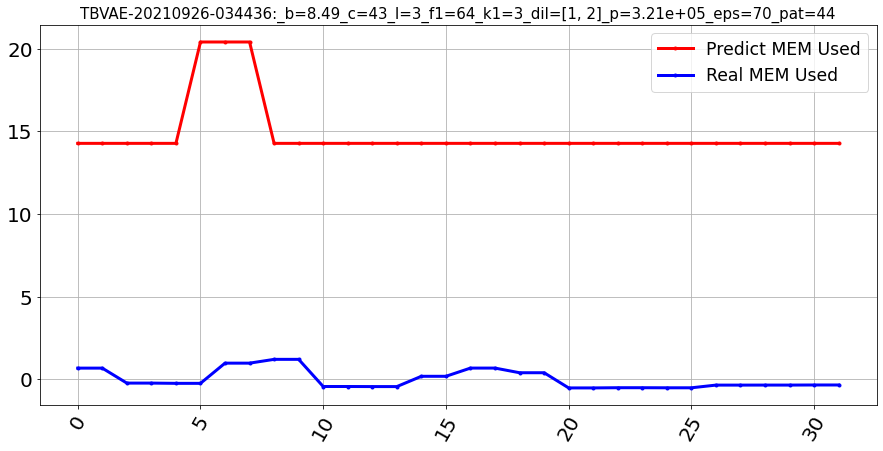


### Run no. 9
Shape of Z: (None, 1144)

 TBVAE-20210926-035614:_b=4.19_c=51_l=2_f1=143_k1=3_dil=[1, 2]_p=1.11e+06_eps=70_pat=30 



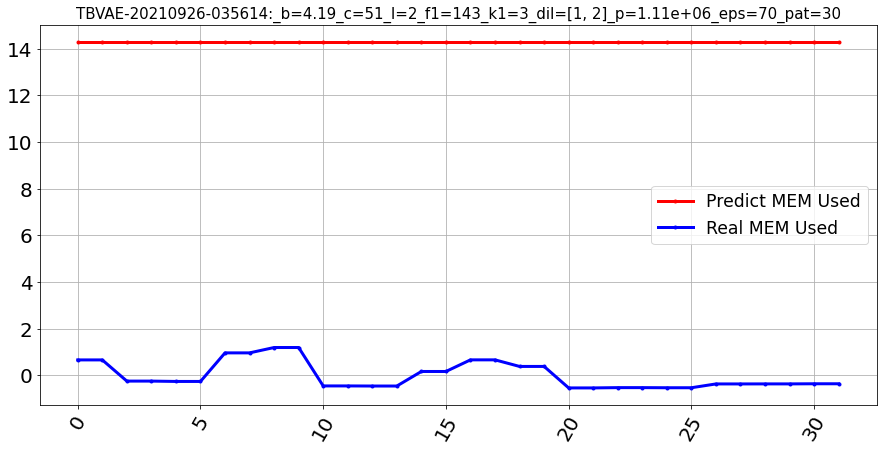


### Run no. 10
Shape of Z: (None, 312)

 TBVAE-20210926-040806:_b=5.64_c=21_l=2_f1=39_k1=4_dil=[1, 2, 4]_p=1.63e+05_eps=70_pat=49 

Restoring model weights from the end of the best epoch.
Epoch 00063: early stopping


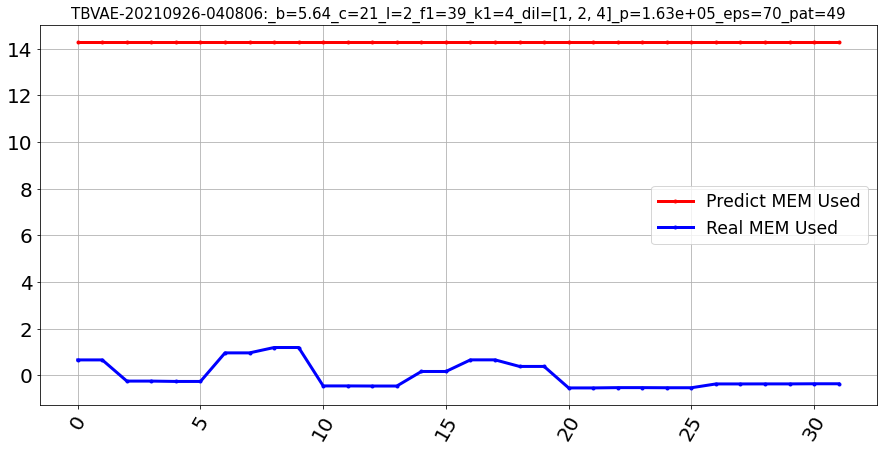


### Run no. 11
Shape of Z: (None, 2000)

 TBVAE-20210926-041709:_b=1.91_c=21_l=2_f1=250_k1=2_dil=[1, 2, 4, 8]_p=4.02e+06_eps=70_pat=46 

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping


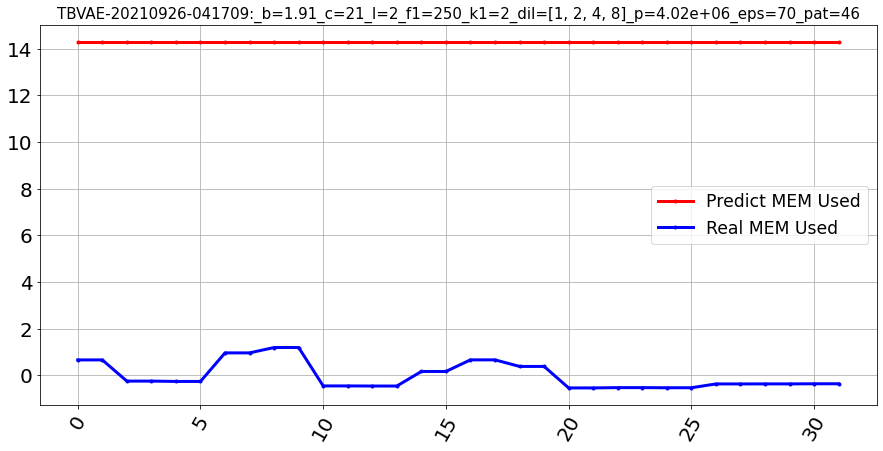


### Run no. 12
Shape of Z: (None, 1400)

 TBVAE-20210926-043700:_b=9.13_c=50_l=2_f1=175_k1=2_dil=[1, 2, 4]_p=1.63e+06_eps=70_pat=46 

Restoring model weights from the end of the best epoch.
Epoch 00052: early stopping


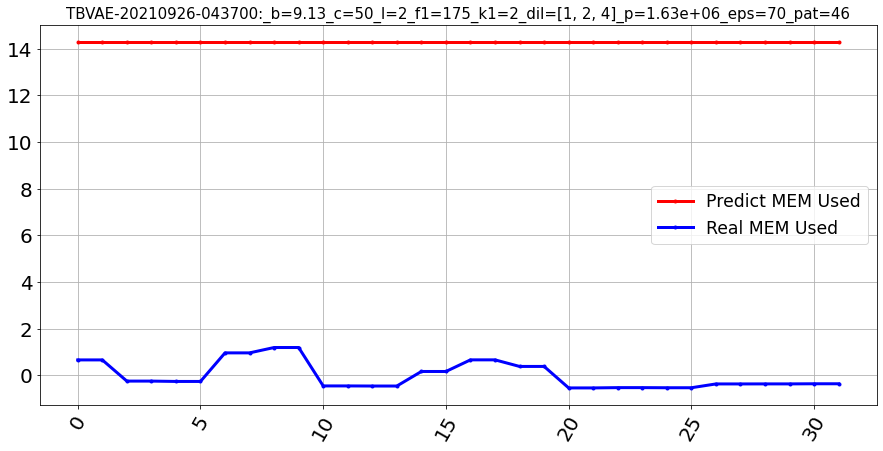


### Run no. 13
Shape of Z: (None, 352)

 TBVAE-20210926-044934:_b=2.44_c=5_l=1_f1=22_k1=3_dil=[1, 2]_p=1.68e+04_eps=70_pat=45 



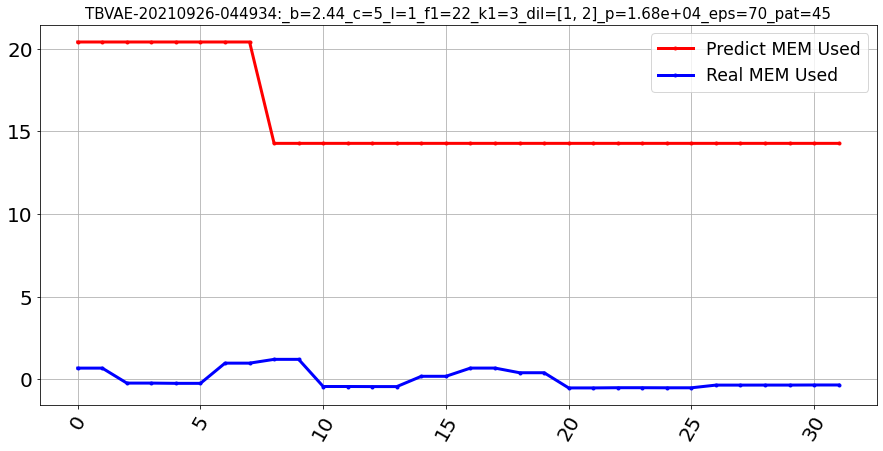


### Run no. 14
Shape of Z: (None, 256)

 TBVAE-20210926-045434:_b=8.85_c=55_l=1_f1=16_k1=7_dil=[1, 2]_p=5.64e+04_eps=70_pat=42 



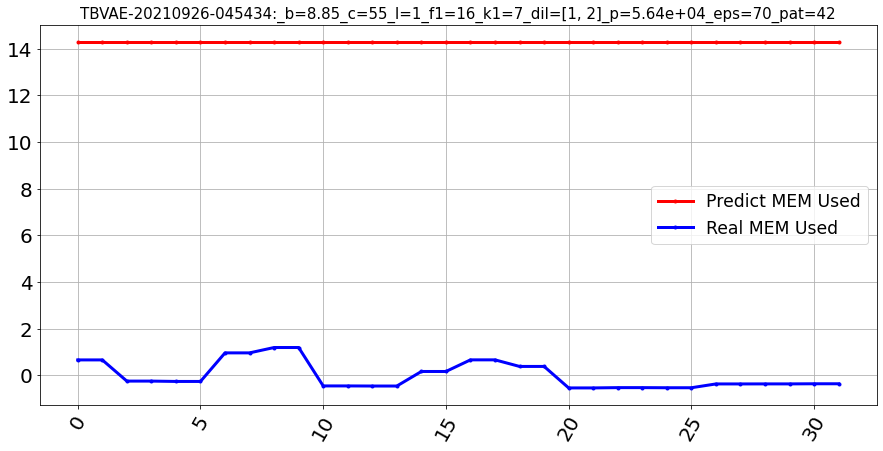


### Run no. 15
Shape of Z: (None, 3584)

 TBVAE-20210926-045939:_b=7.29_c=13_l=1_f1=224_k1=3_dil=[1, 2, 4, 8]_p=2.41e+06_eps=70_pat=44 

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping


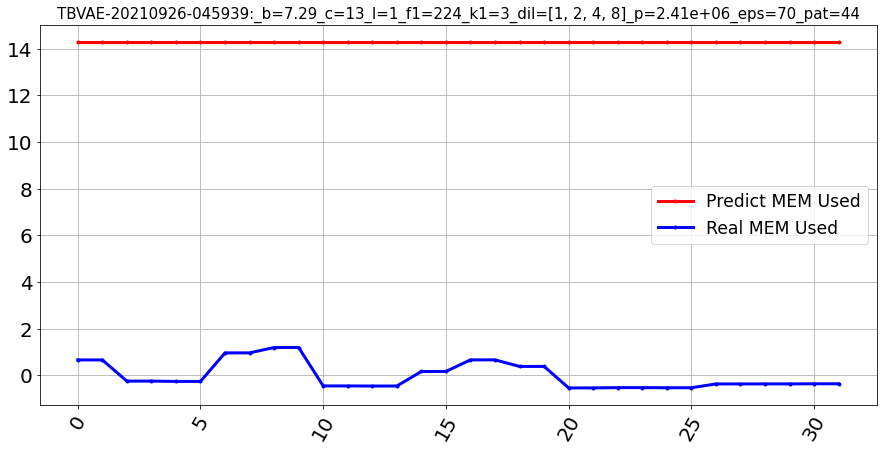


### Run no. 16
Shape of Z: (None, 2400)

 TBVAE-20210926-051049:_b=1.85_c=39_l=1_f1=150_k1=6_dil=[1, 2, 4]_p=1.78e+06_eps=70_pat=34 

Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping


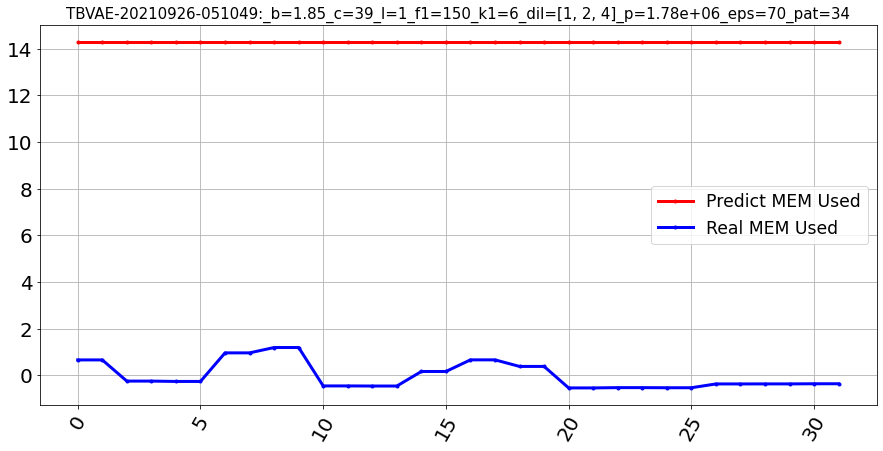


### Run no. 17
Shape of Z: (None, 3024)

 TBVAE-20210926-051745:_b=3.26_c=17_l=1_f1=189_k1=7_dil=[1, 2, 4]_p=2.92e+06_eps=70_pat=38 

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping


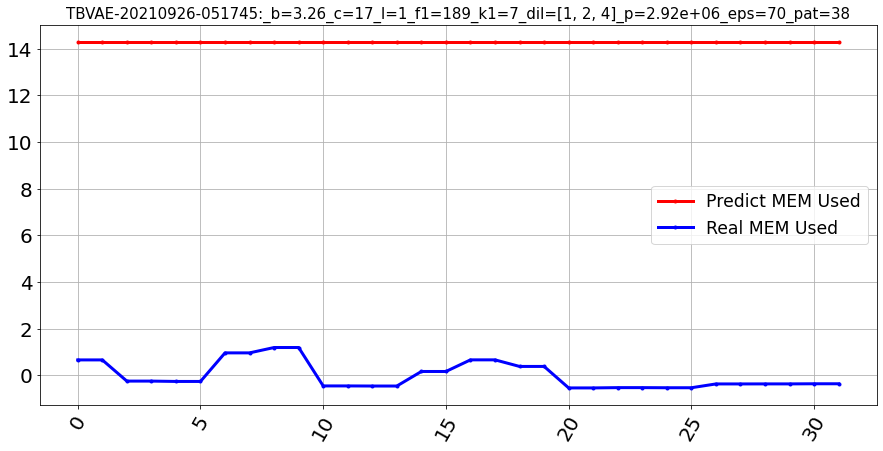


### Run no. 18
Shape of Z: (None, 1576)

 TBVAE-20210926-052629:_b=5.03_c=43_l=2_f1=197_k1=4_dil=[1, 2]_p=2.55e+06_eps=70_pat=39 



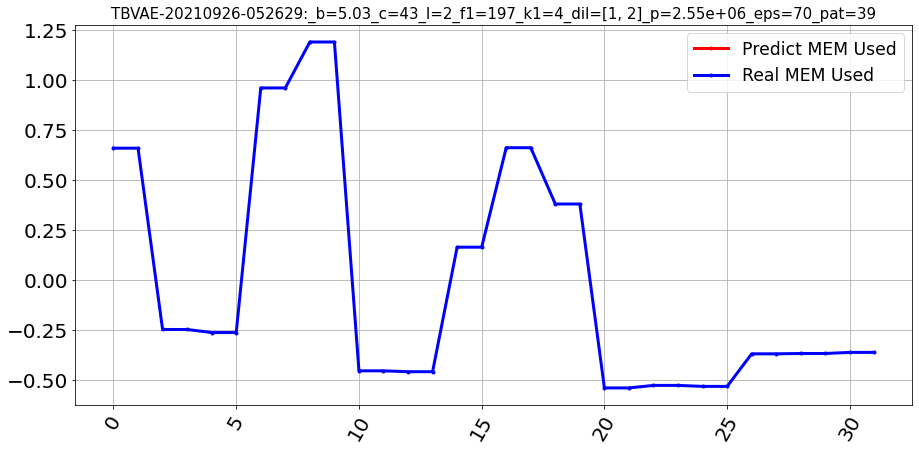


### Run no. 19
Shape of Z: (None, 3248)

 TBVAE-20210926-054119:_b=3.39_c=45_l=1_f1=203_k1=2_dil=[1, 2]_p=1.03e+06_eps=70_pat=34 



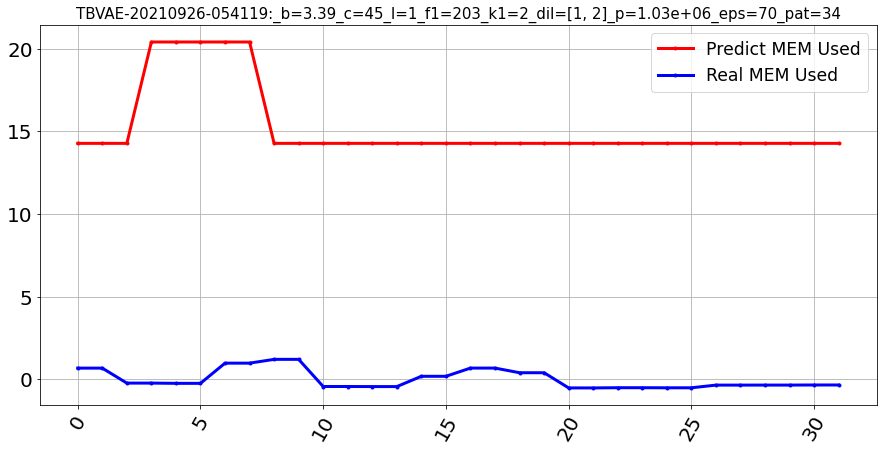


### Run no. 20
Shape of Z: (None, 1848)

 TBVAE-20210926-054951:_b=7.24_c=46_l=2_f1=231_k1=8_dil=[1, 2, 4, 8]_p=1.35e+07_eps=70_pat=42 

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping


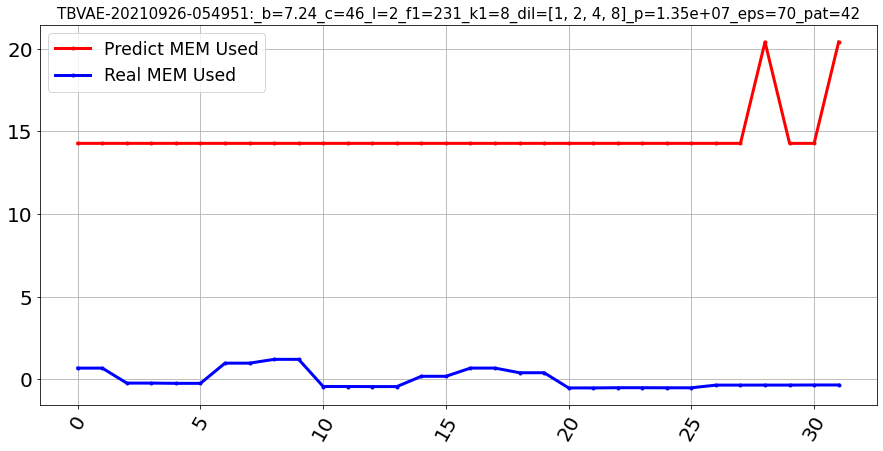


### Run no. 21
Shape of Z: (None, 232)

 TBVAE-20210926-061723:_b=2.43_c=57_l=2_f1=29_k1=2_dil=[1, 2, 4]_p=8.05e+04_eps=70_pat=49 



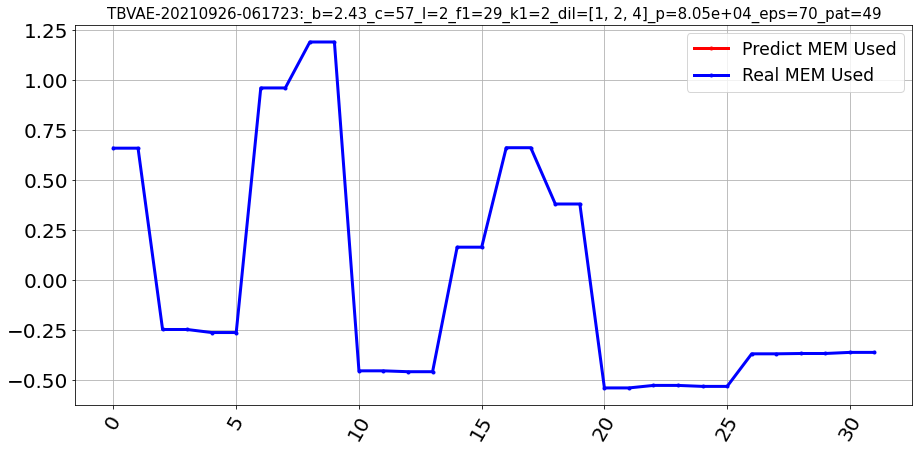


### Run no. 22
Shape of Z: (None, 720)

 TBVAE-20210926-062718:_b=8.00_c=40_l=2_f1=90_k1=4_dil=[1, 2]_p=5.79e+05_eps=70_pat=35 



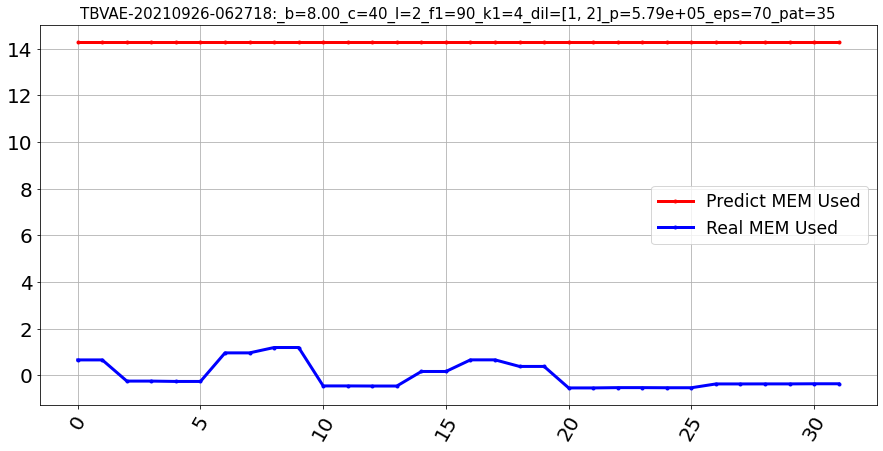


### Run no. 23
Shape of Z: (None, 844)

 TBVAE-20210926-063610:_b=0.73_c=56_l=3_f1=211_k1=5_dil=[1, 2, 4]_p=7.96e+06_eps=70_pat=31 

Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping


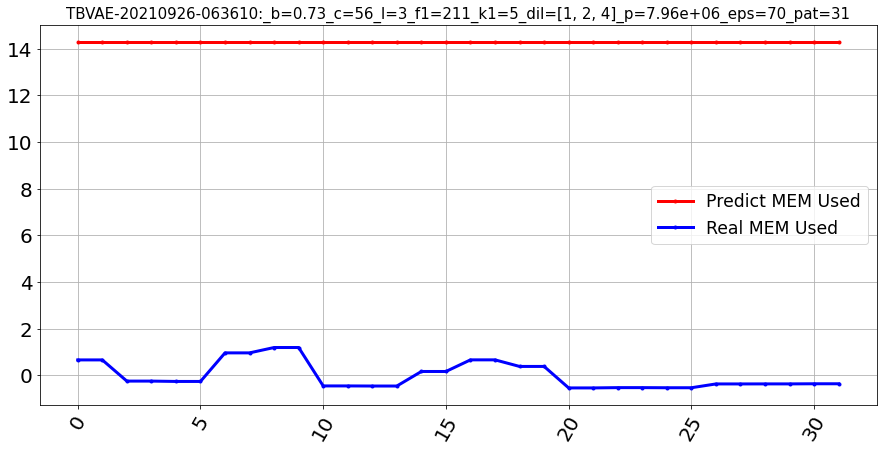


### Run no. 24
Shape of Z: (None, 1056)

 TBVAE-20210926-065136:_b=7.68_c=38_l=2_f1=132_k1=5_dil=[1, 2, 4, 8]_p=2.83e+06_eps=70_pat=30 

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping


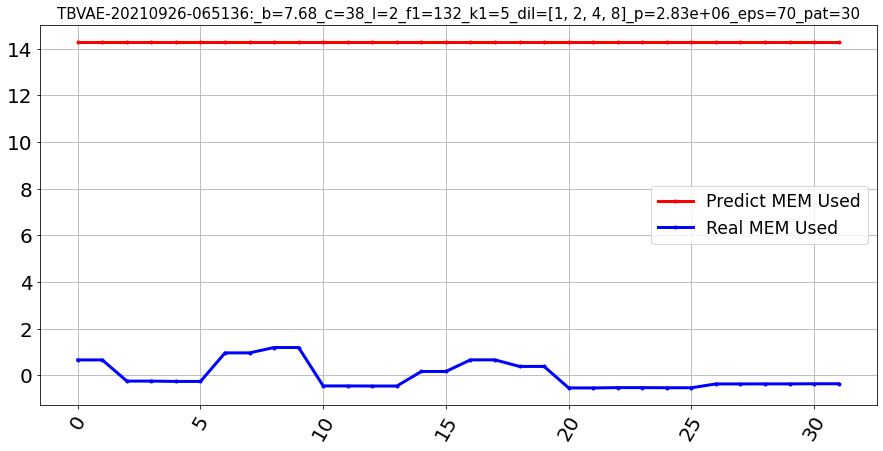


### Run no. 25
Shape of Z: (None, 736)

 TBVAE-20210926-070244:_b=5.01_c=8_l=2_f1=92_k1=8_dil=[1, 2, 4]_p=1.59e+06_eps=70_pat=37 

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping


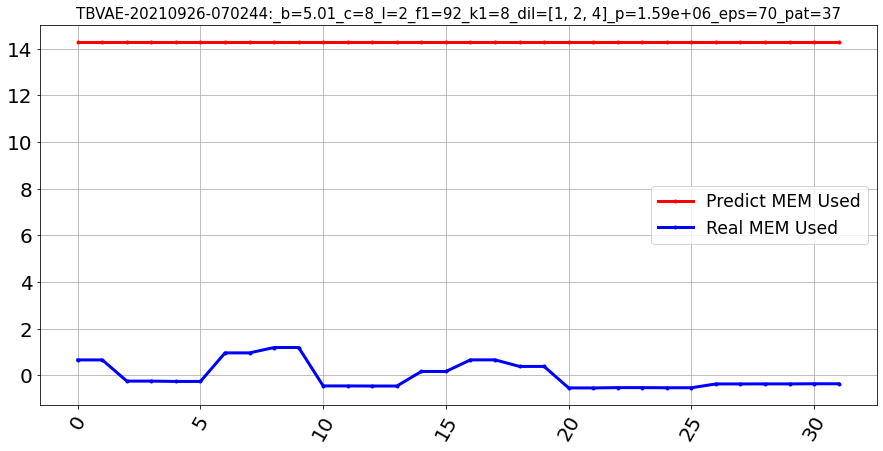


### Run no. 26
Shape of Z: (None, 428)

 TBVAE-20210926-071119:_b=1.62_c=56_l=3_f1=107_k1=8_dil=[1, 2, 4, 8]_p=4.39e+06_eps=70_pat=49 

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping


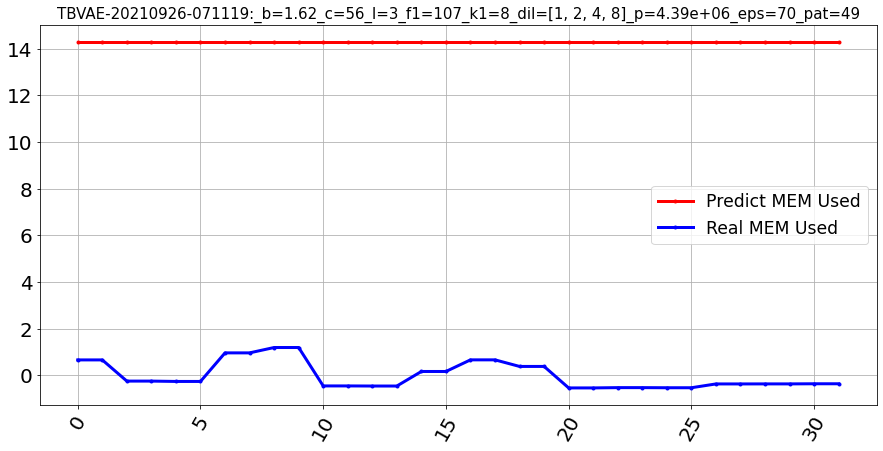


### Run no. 27
Shape of Z: (None, 1880)

 TBVAE-20210926-073405:_b=8.39_c=43_l=2_f1=235_k1=6_dil=[1, 2, 4, 8]_p=1.05e+07_eps=70_pat=46 

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
list index out of range
TRACEBACK

### Run no. 28


Traceback (most recent call last):
  File "C:\Users\user\AppData\Local\Temp/ipykernel_7620/580798722.py", line 141, in <module>
    results = [[p_bvae[i][k] for k in p_bvae[i]] + list(results[0])]
IndexError: list index out of range


Shape of Z: (None, 560)

 TBVAE-20210926-080047:_b=6.46_c=56_l=2_f1=70_k1=2_dil=[1, 2, 4, 8]_p=4.03e+05_eps=70_pat=49 

Restoring model weights from the end of the best epoch.
Epoch 00052: early stopping


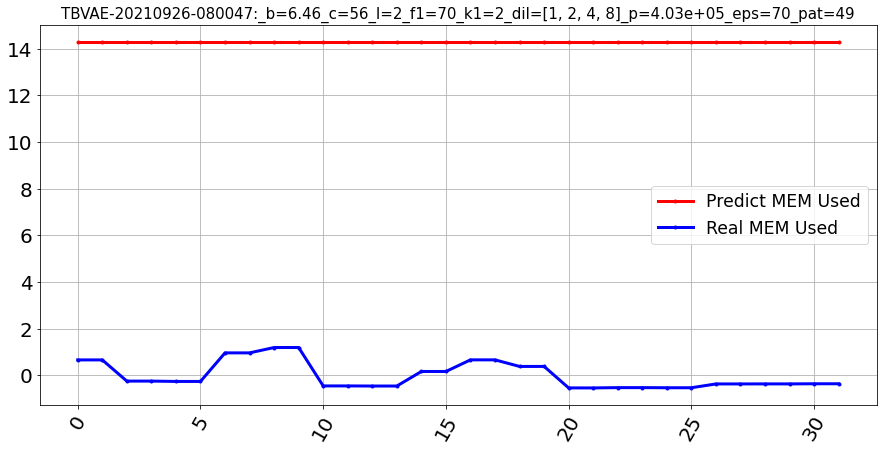


### Run no. 29
Shape of Z: (None, 244)

 TBVAE-20210926-081103:_b=3.38_c=12_l=3_f1=61_k1=8_dil=[1, 2, 4]_p=1.06e+06_eps=70_pat=30 

Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping


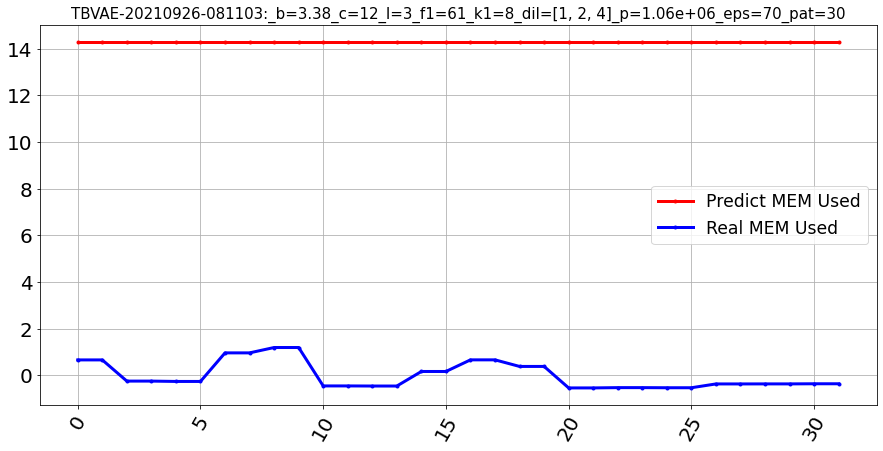


### Run no. 30
Shape of Z: (None, 888)

 TBVAE-20210926-082026:_b=4.36_c=6_l=2_f1=111_k1=7_dil=[1, 2, 4]_p=2.01e+06_eps=70_pat=47 

Restoring model weights from the end of the best epoch.
Epoch 00051: early stopping


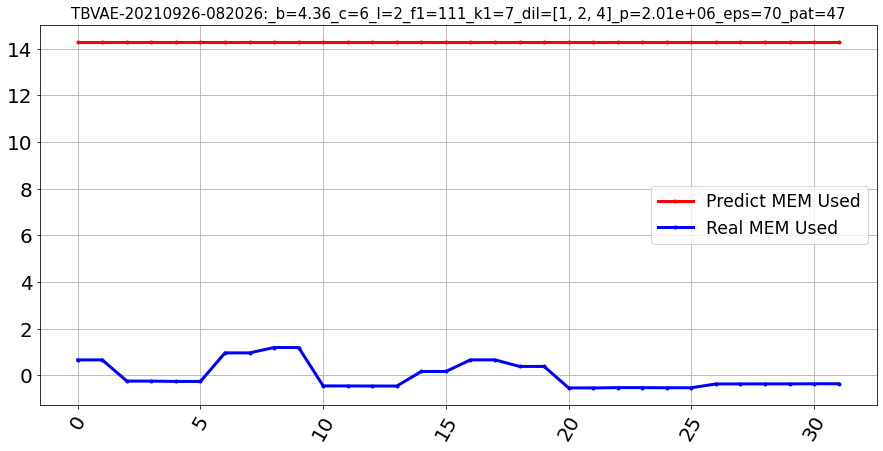


### Run no. 31
Shape of Z: (None, 3104)

 TBVAE-20210926-083208:_b=3.73_c=44_l=1_f1=194_k1=5_dil=[1, 2, 4, 8]_p=3.25e+06_eps=70_pat=31 

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping


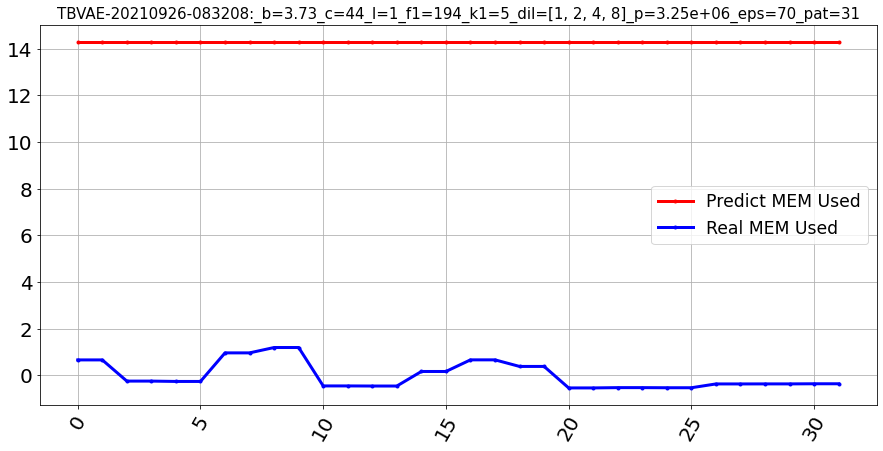


### Run no. 32
Shape of Z: (None, 780)

 TBVAE-20210926-084114:_b=6.26_c=42_l=3_f1=195_k1=7_dil=[1, 2]_p=6.24e+06_eps=70_pat=45 



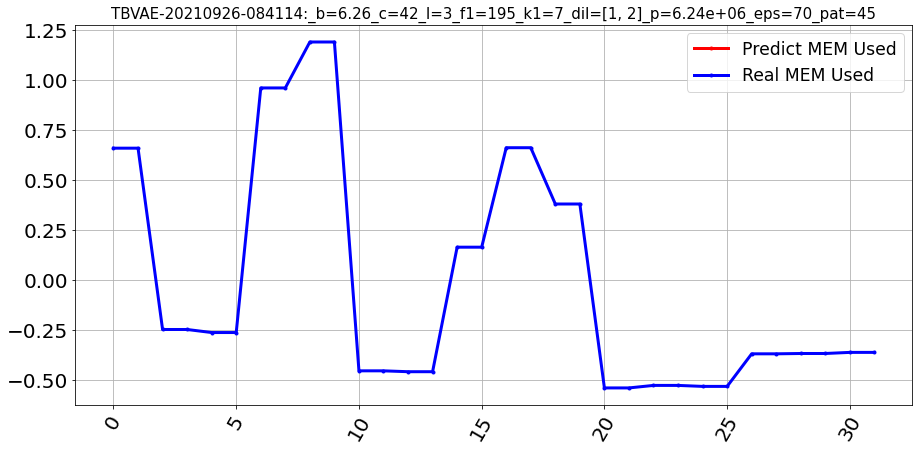


### Run no. 33
Shape of Z: (None, 2304)

 TBVAE-20210926-090346:_b=5.65_c=41_l=1_f1=144_k1=8_dil=[1, 2, 4]_p=2.12e+06_eps=70_pat=44 

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping


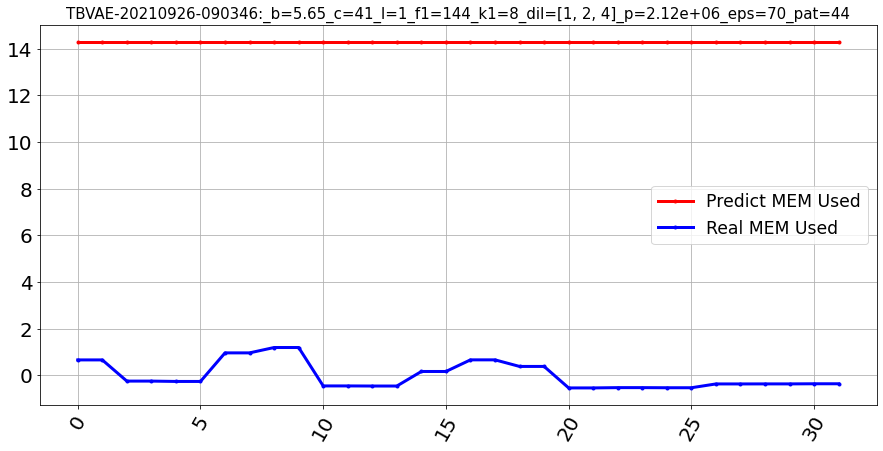


### Run no. 34
Shape of Z: (None, 440)

 TBVAE-20210926-091239:_b=1.39_c=51_l=2_f1=55_k1=3_dil=[1, 2]_p=2.07e+05_eps=70_pat=44 



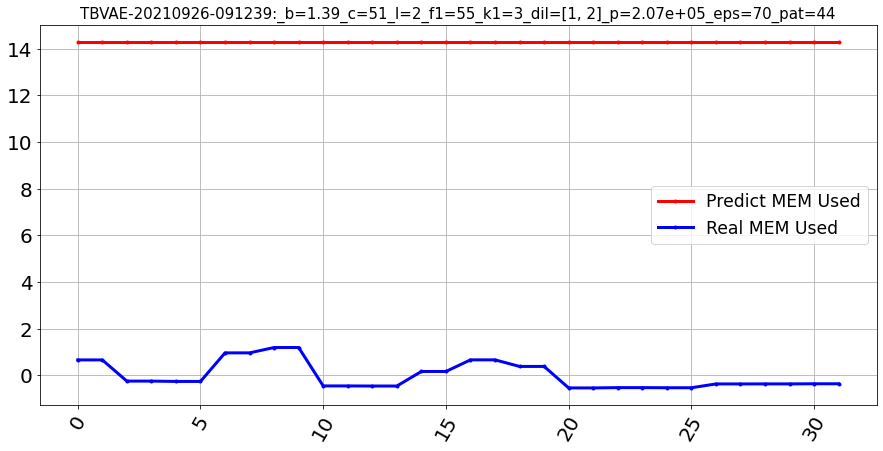


### Run no. 35
Shape of Z: (None, 364)

 TBVAE-20210926-092040:_b=1.44_c=25_l=3_f1=91_k1=7_dil=[1, 2, 4]_p=2.07e+06_eps=70_pat=47 

Restoring model weights from the end of the best epoch.
Epoch 00052: early stopping


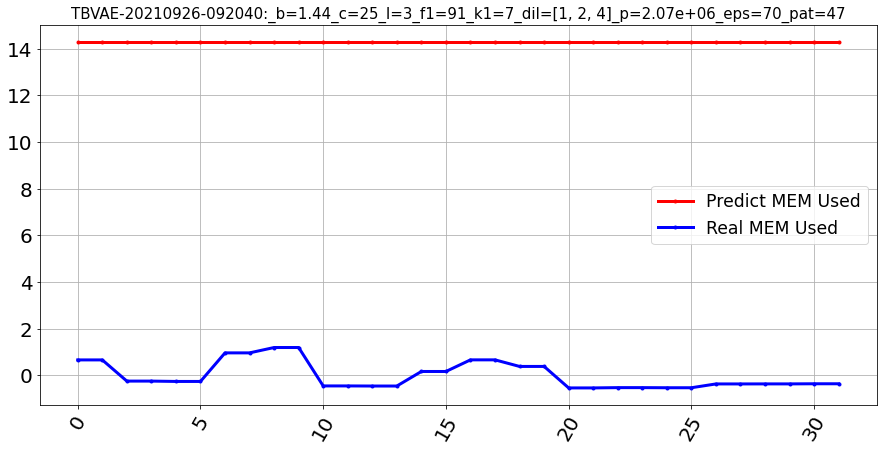


### Run no. 36
Shape of Z: (None, 2832)

 TBVAE-20210926-093559:_b=3.30_c=45_l=1_f1=177_k1=4_dil=[1, 2]_p=1.27e+06_eps=70_pat=47 



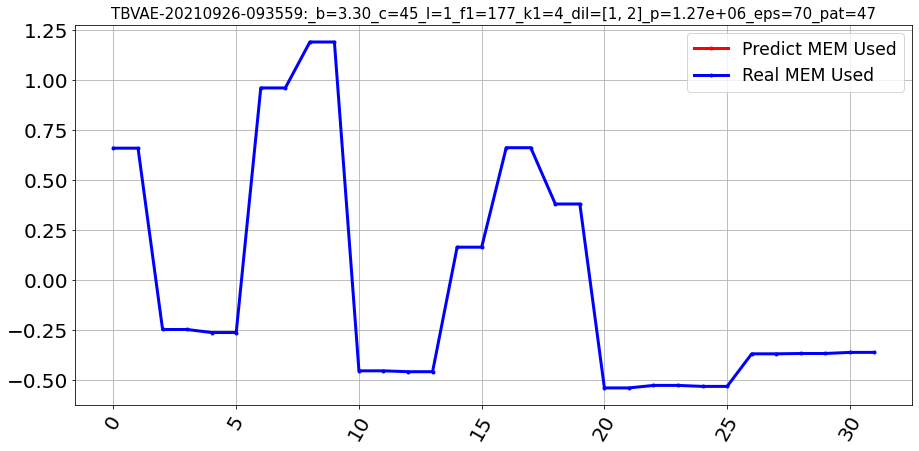


### Run no. 37
Shape of Z: (None, 420)

 TBVAE-20210926-094507:_b=5.57_c=54_l=3_f1=105_k1=8_dil=[1, 2]_p=2.11e+06_eps=70_pat=32 



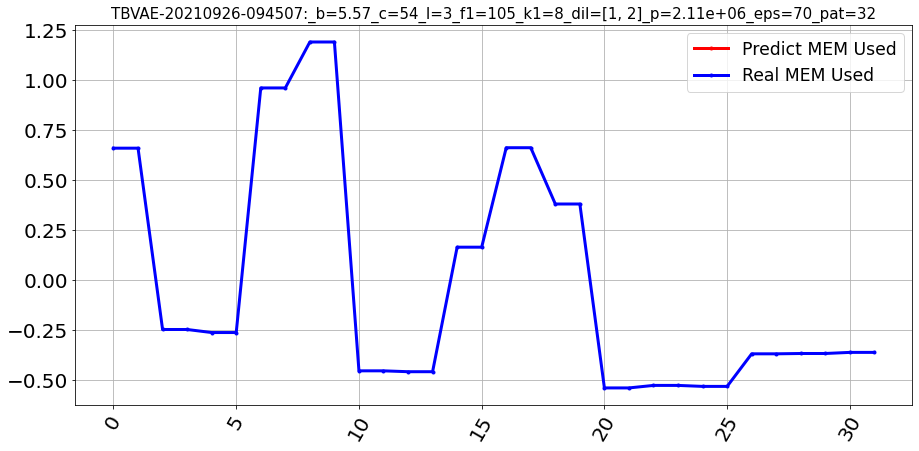


### Run no. 38
Shape of Z: (None, 232)

 TBVAE-20210926-100011:_b=7.85_c=61_l=3_f1=58_k1=7_dil=[1, 2, 4]_p=8.74e+05_eps=70_pat=45 

Restoring model weights from the end of the best epoch.
Epoch 00052: early stopping


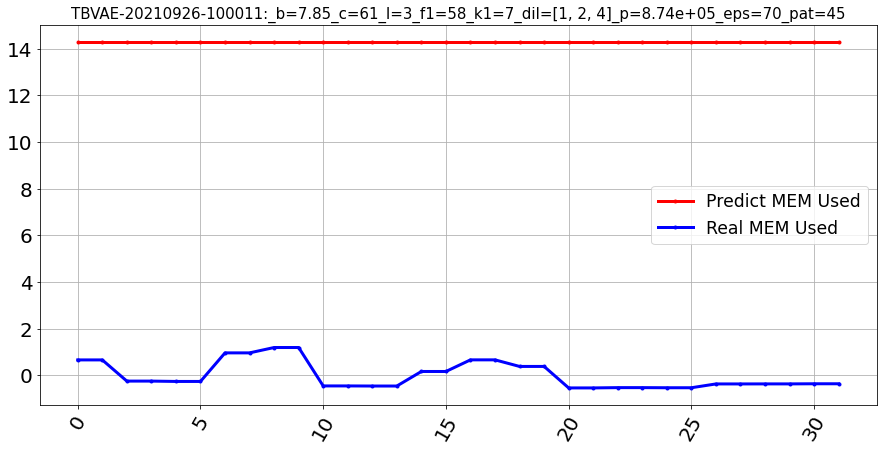


### Run no. 39
Shape of Z: (None, 492)

 TBVAE-20210926-101143:_b=3.47_c=28_l=3_f1=123_k1=3_dil=[1, 2, 4]_p=1.64e+06_eps=70_pat=36 

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping


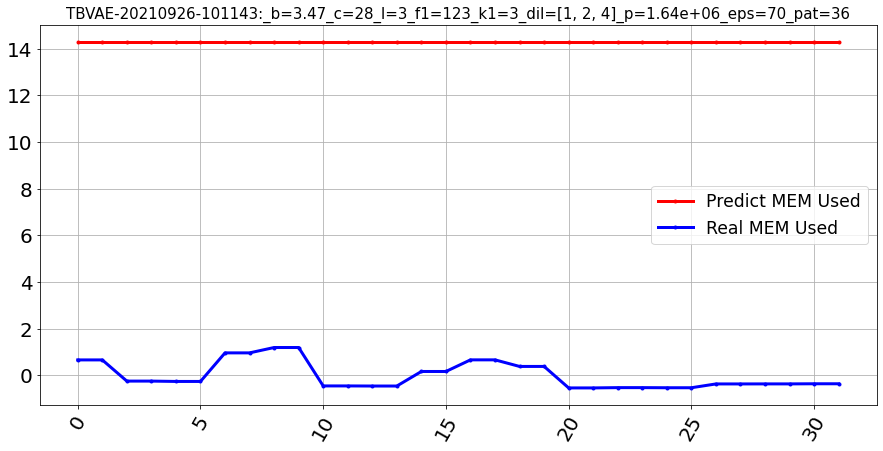


### Run no. 40
Shape of Z: (None, 720)

 TBVAE-20210926-102255:_b=9.29_c=8_l=1_f1=45_k1=8_dil=[1, 2]_p=1.35e+05_eps=70_pat=31 



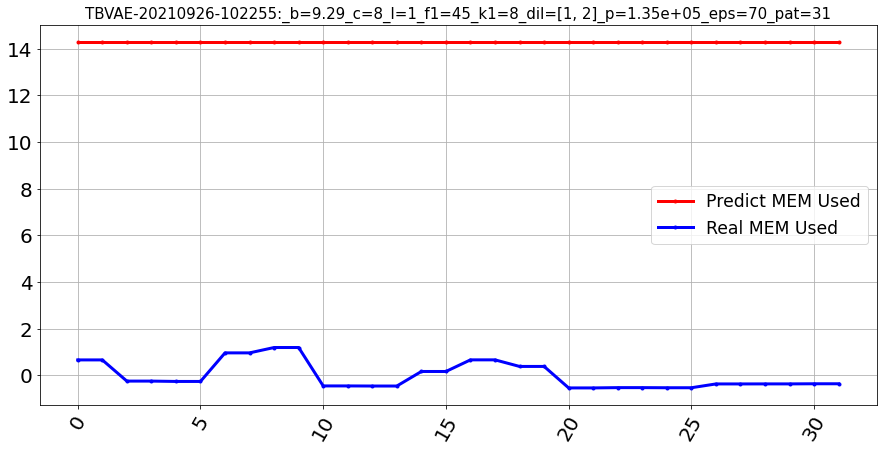


### Run no. 41
Shape of Z: (None, 1528)

 TBVAE-20210926-102754:_b=2.01_c=59_l=2_f1=191_k1=4_dil=[1, 2]_p=2.47e+06_eps=70_pat=32 

Restoring model weights from the end of the best epoch.
Epoch 00056: early stopping


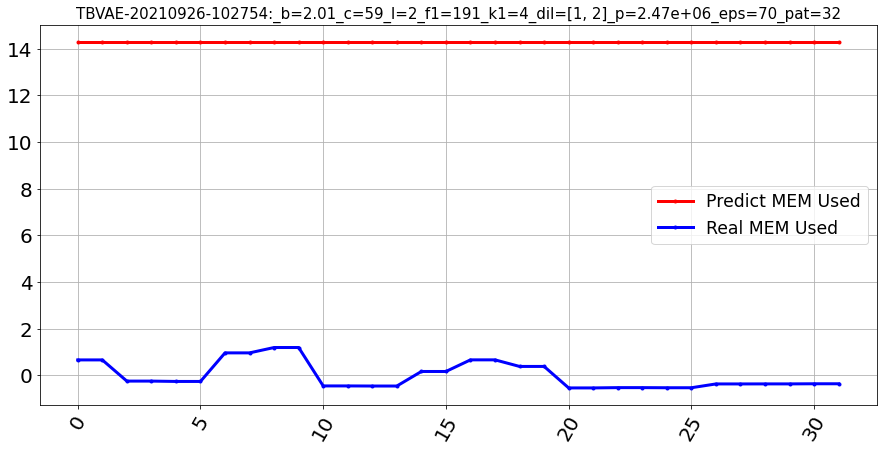


### Run no. 42
Shape of Z: (None, 2192)

 TBVAE-20210926-103946:_b=8.62_c=60_l=1_f1=137_k1=5_dil=[1, 2]_p=1.06e+06_eps=70_pat=49 



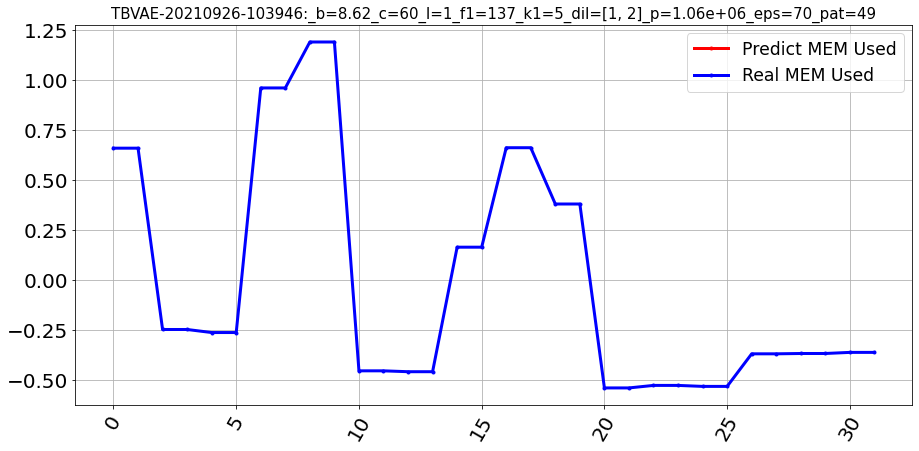


### Run no. 43
Shape of Z: (None, 2560)

 TBVAE-20210926-104755:_b=5.23_c=25_l=1_f1=160_k1=7_dil=[1, 2, 4]_p=2.18e+06_eps=70_pat=46 

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping


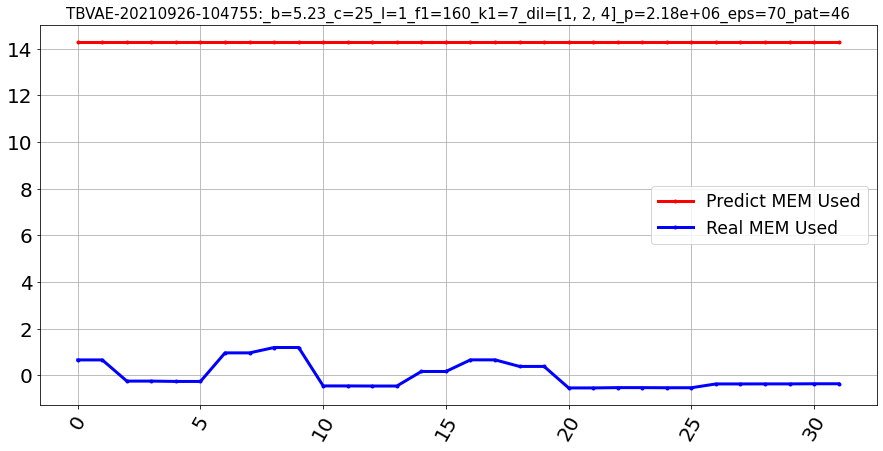


### Run no. 44
Shape of Z: (None, 224)

 TBVAE-20210926-105721:_b=2.08_c=18_l=2_f1=28_k1=3_dil=[1, 2]_p=4.93e+04_eps=70_pat=47 



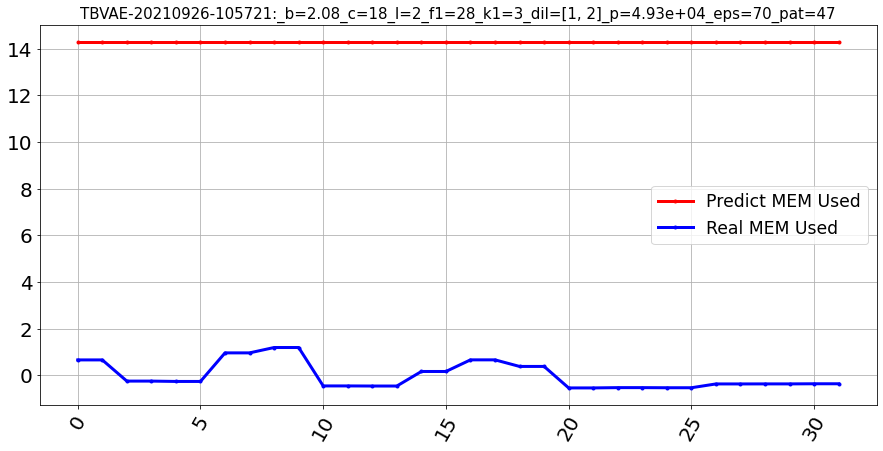


### Run no. 45
Shape of Z: (None, 416)

 TBVAE-20210926-110550:_b=7.83_c=52_l=3_f1=104_k1=8_dil=[1, 2, 4, 8]_p=4.15e+06_eps=70_pat=48 

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping


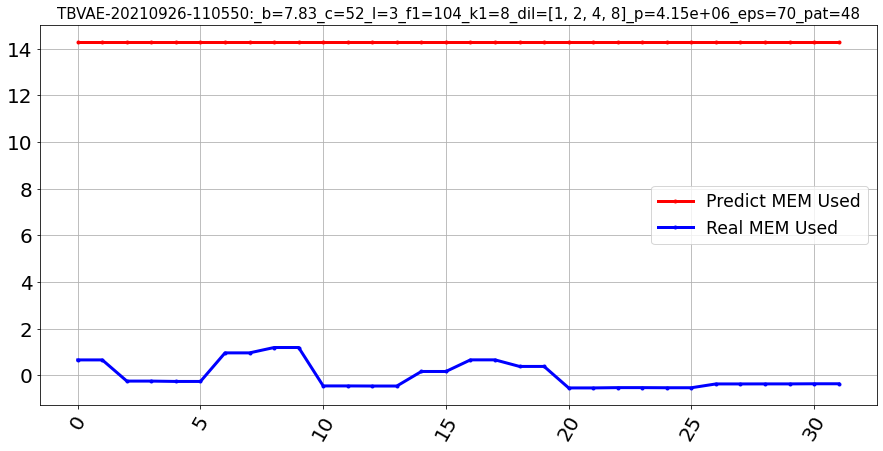


### Run no. 46
Shape of Z: (None, 3424)

 TBVAE-20210926-112547:_b=8.93_c=63_l=1_f1=214_k1=2_dil=[1, 2]_p=1.30e+06_eps=70_pat=36 



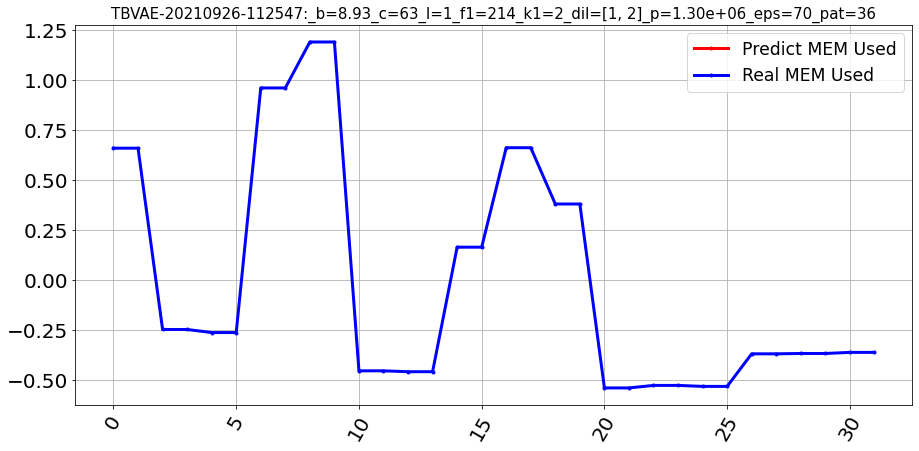


### Run no. 47
Shape of Z: (None, 928)

 TBVAE-20210926-113421:_b=4.90_c=47_l=1_f1=58_k1=7_dil=[1, 2]_p=3.01e+05_eps=70_pat=32 



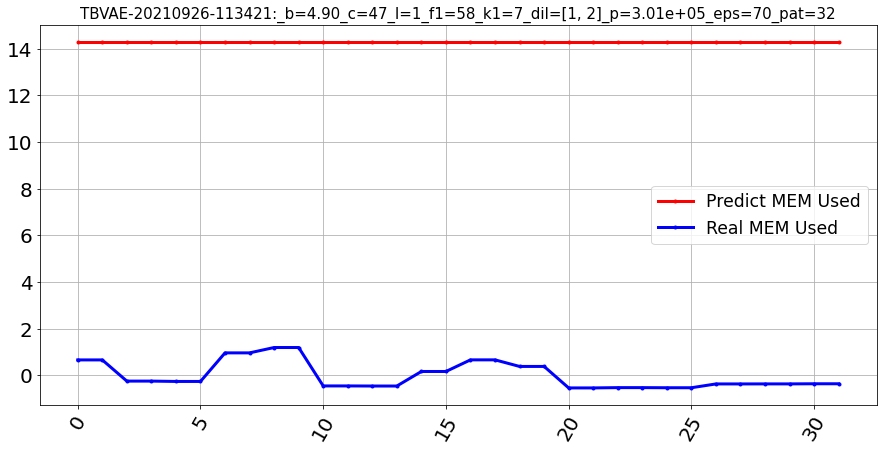


### Run no. 48
Shape of Z: (None, 1920)

 TBVAE-20210926-113934:_b=1.57_c=14_l=1_f1=120_k1=6_dil=[1, 2, 4]_p=1.04e+06_eps=70_pat=31 

Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping


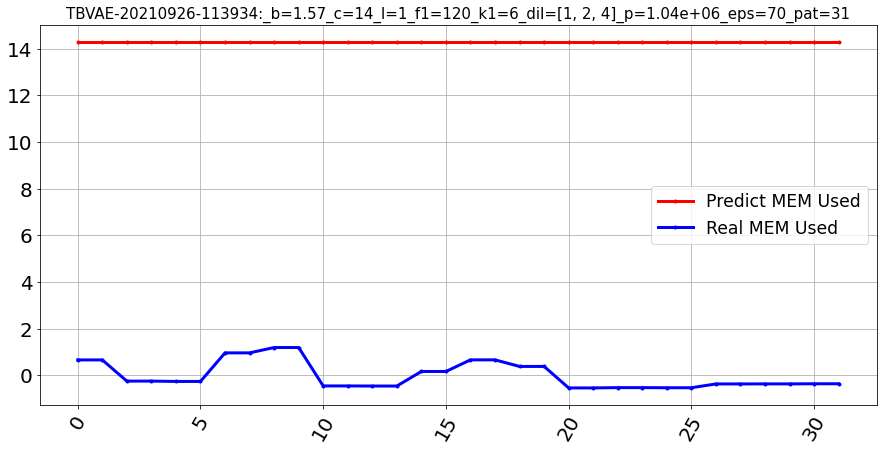


### Run no. 49
Shape of Z: (None, 1520)

 TBVAE-20210926-114408:_b=7.10_c=41_l=1_f1=95_k1=7_dil=[1, 2, 4]_p=8.91e+05_eps=70_pat=42 

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping


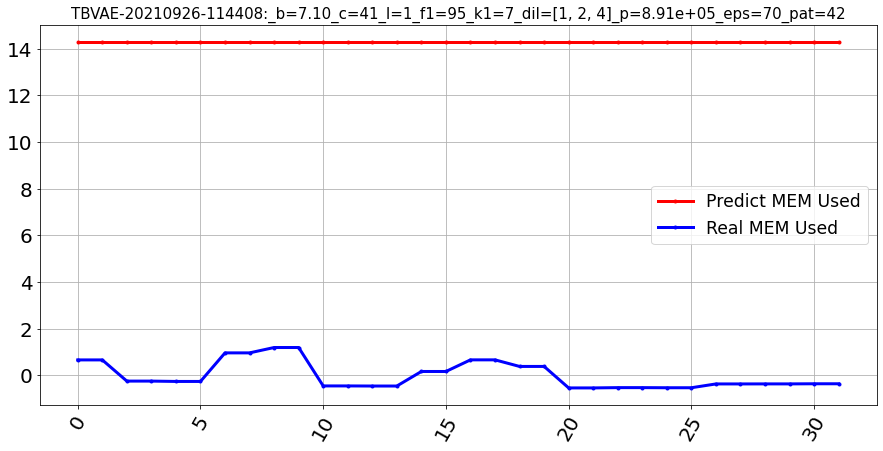


### Run no. 50
Shape of Z: (None, 552)

 TBVAE-20210926-115013:_b=5.11_c=18_l=2_f1=69_k1=5_dil=[1, 2]_p=3.93e+05_eps=70_pat=36 



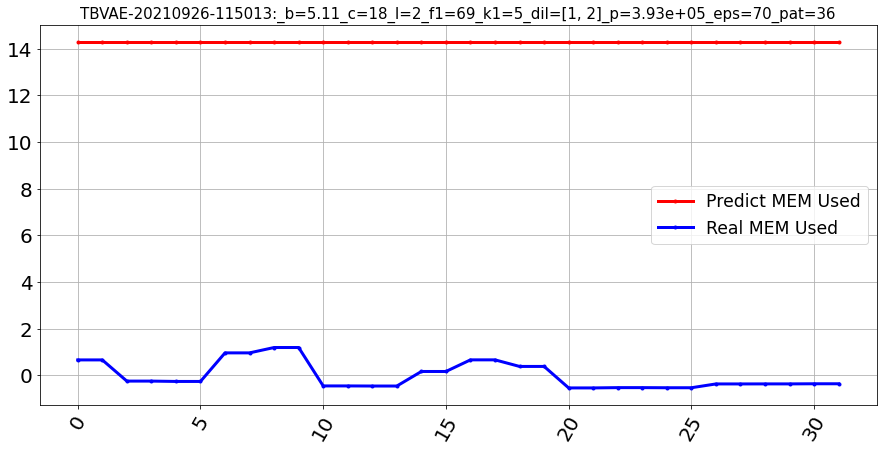


### Run no. 51
Shape of Z: (None, 368)

 TBVAE-20210926-115854:_b=8.72_c=54_l=1_f1=23_k1=5_dil=[1, 2, 4]_p=9.07e+04_eps=70_pat=35 

Restoring model weights from the end of the best epoch.
Epoch 00058: early stopping


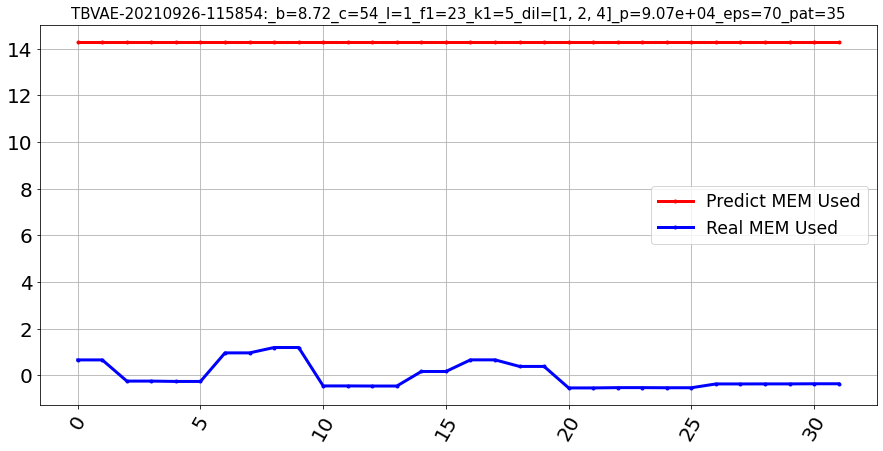


### Run no. 52
Shape of Z: (None, 496)

 TBVAE-20210926-120358:_b=6.35_c=36_l=1_f1=31_k1=3_dil=[1, 2, 4, 8]_p=9.90e+04_eps=70_pat=43 

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping


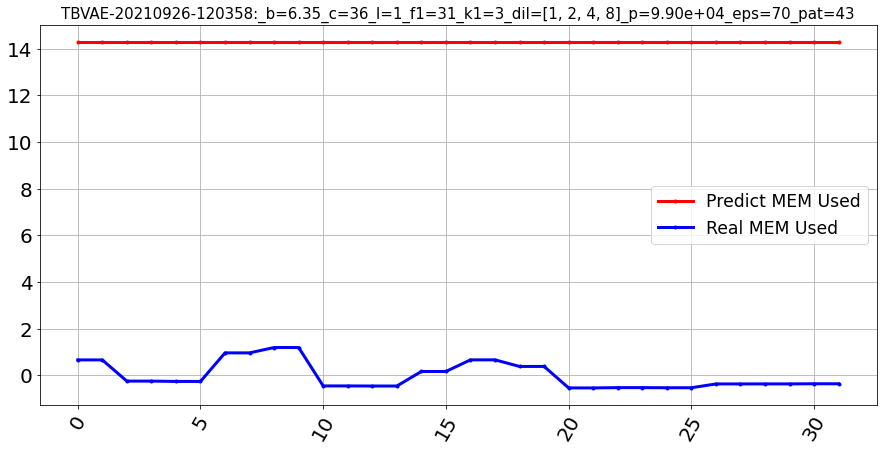


### Run no. 53
Shape of Z: (None, 1600)

 TBVAE-20210926-120913:_b=8.72_c=29_l=1_f1=100_k1=7_dil=[1, 2, 4, 8]_p=1.20e+06_eps=70_pat=36 

Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping


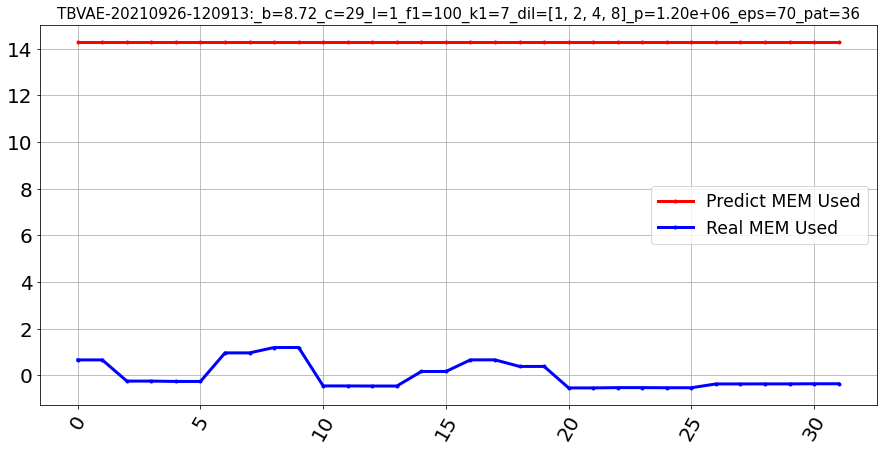


### Run no. 54
Shape of Z: (None, 852)

 TBVAE-20210926-121521:_b=1.17_c=19_l=3_f1=213_k1=5_dil=[1, 2, 4, 8]_p=1.07e+07_eps=70_pat=42 

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
list index out of range
TRACEBACK

### Run no. 55


Traceback (most recent call last):
  File "C:\Users\user\AppData\Local\Temp/ipykernel_7620/580798722.py", line 141, in <module>
    results = [[p_bvae[i][k] for k in p_bvae[i]] + list(results[0])]
IndexError: list index out of range


Shape of Z: (None, 716)

 TBVAE-20210926-124117:_b=3.64_c=60_l=3_f1=179_k1=7_dil=[1, 2, 4, 8]_p=1.07e+07_eps=70_pat=42 

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping


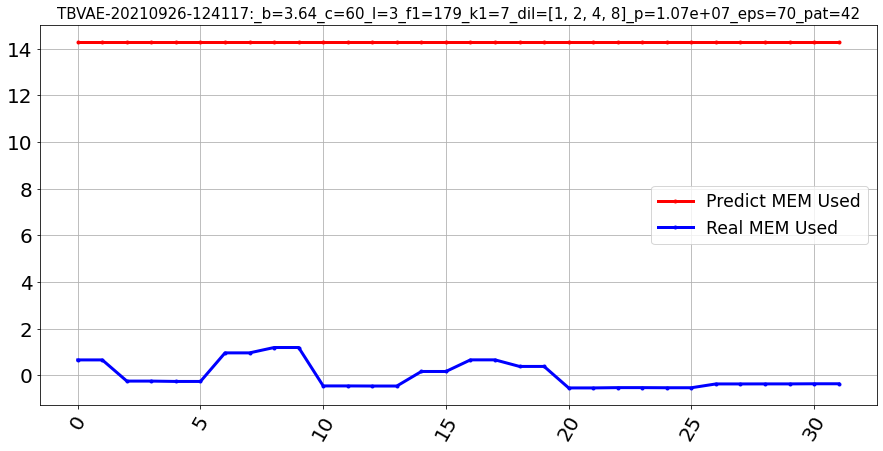


### Run no. 56
Shape of Z: (None, 1376)

 TBVAE-20210926-131010:_b=8.48_c=49_l=2_f1=172_k1=2_dil=[1, 2]_p=1.10e+06_eps=70_pat=39 



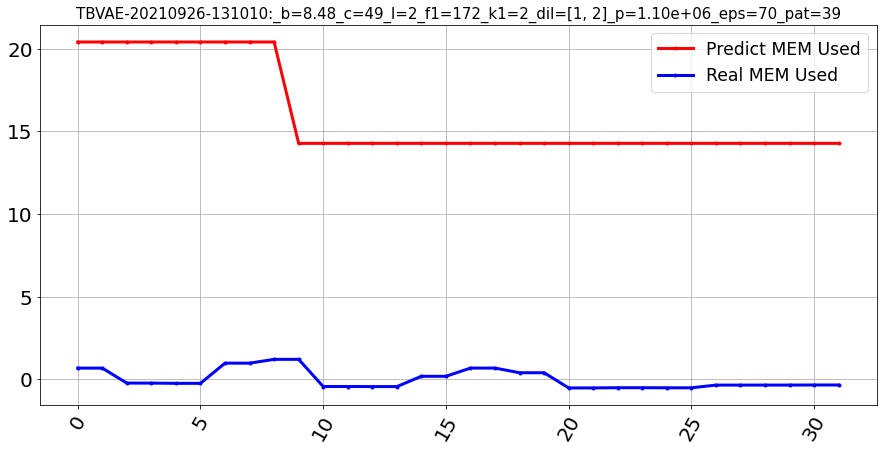


### Run no. 57
Shape of Z: (None, 3024)

 TBVAE-20210926-132129:_b=8.20_c=51_l=1_f1=189_k1=6_dil=[1, 2, 4, 8]_p=3.70e+06_eps=70_pat=44 

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping


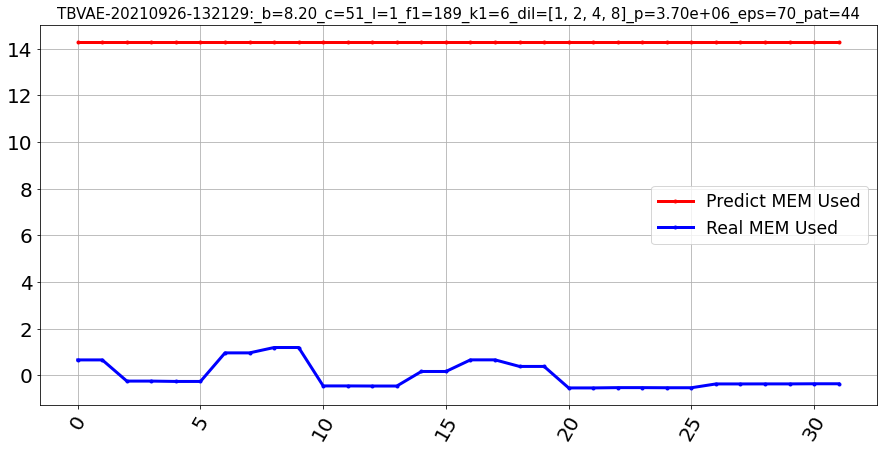


### Run no. 58
Shape of Z: (None, 760)

 TBVAE-20210926-133440:_b=5.00_c=45_l=2_f1=95_k1=8_dil=[1, 2, 4, 8]_p=2.35e+06_eps=70_pat=44 

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping


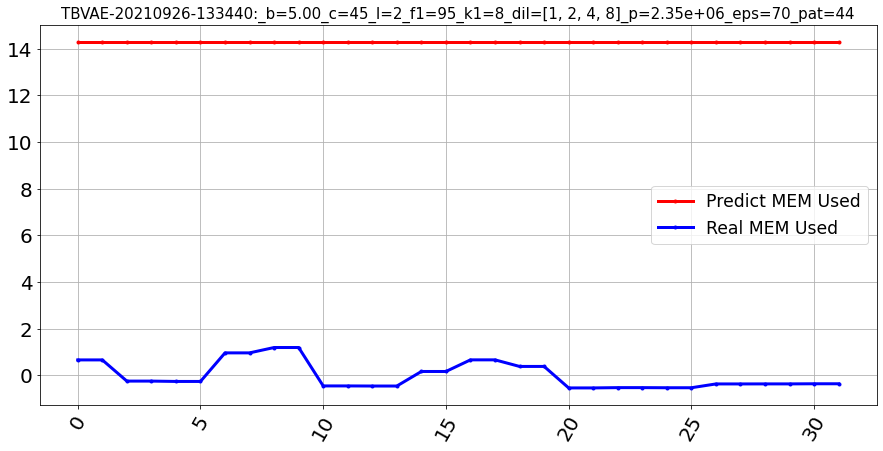


### Run no. 59
Shape of Z: (None, 520)

 TBVAE-20210926-134912:_b=4.67_c=23_l=2_f1=65_k1=5_dil=[1, 2, 4]_p=5.28e+05_eps=70_pat=32 

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping


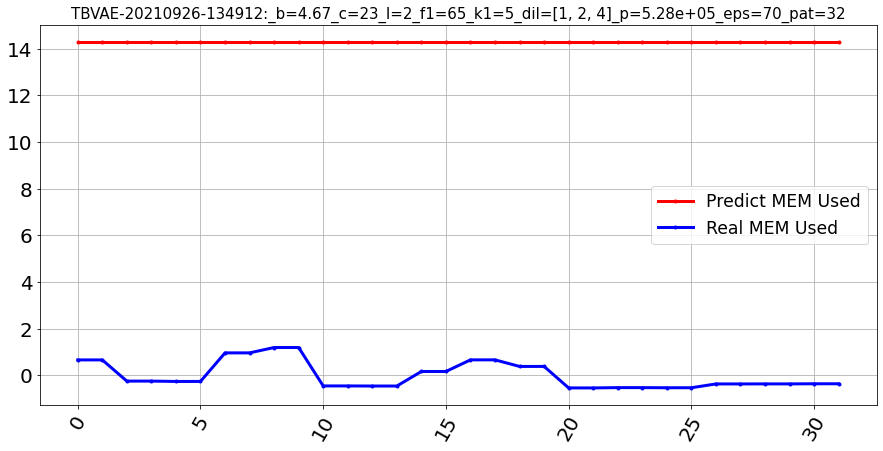


### Run no. 60
Shape of Z: (None, 756)

 TBVAE-20210926-135617:_b=6.00_c=14_l=3_f1=189_k1=3_dil=[1, 2, 4, 8]_p=5.09e+06_eps=70_pat=42 

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping


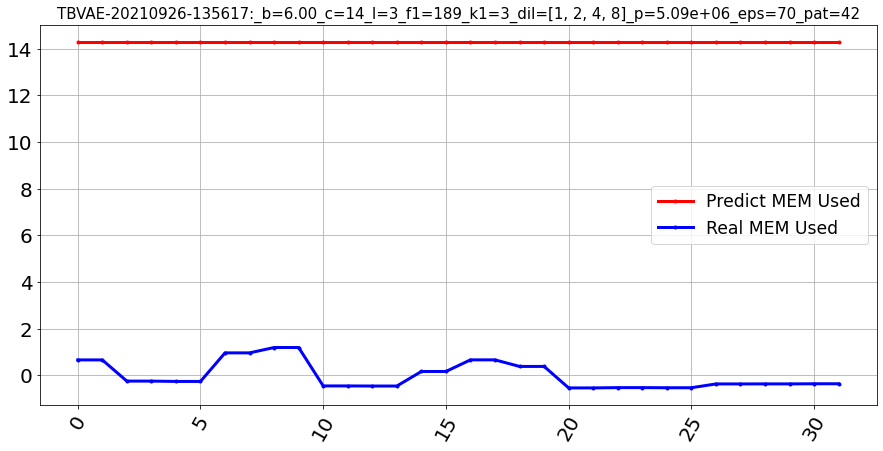


### Run no. 61
Shape of Z: (None, 2008)

 TBVAE-20210926-141712:_b=3.01_c=20_l=2_f1=251_k1=6_dil=[1, 2, 4, 8]_p=1.19e+07_eps=70_pat=48 

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping


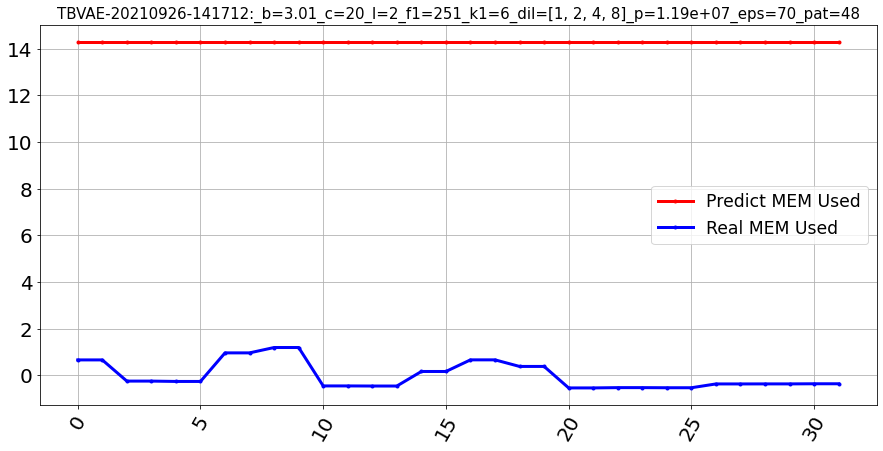


### Run no. 62
Shape of Z: (None, 1200)

 TBVAE-20210926-144710:_b=8.15_c=17_l=2_f1=150_k1=8_dil=[1, 2]_p=2.78e+06_eps=70_pat=38 

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping


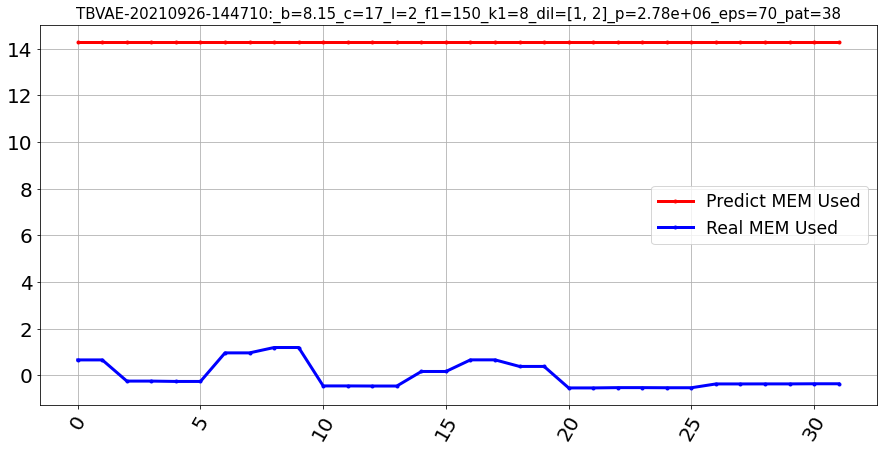


### Run no. 63
Shape of Z: (None, 928)

 TBVAE-20210926-145548:_b=8.96_c=63_l=3_f1=232_k1=2_dil=[1, 2, 4, 8]_p=5.26e+06_eps=70_pat=38 



KeyboardInterrupt: 

In [6]:
from sklearn.utils import shuffle
from sklearn.model_selection import ParameterSampler
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
import traceback,datetime
import numpy as np
import pandas as pd
import TCN_VAE,os 
import importlib
importlib.reload(TCN_VAE)


# Input the number of iterations you want to search over
random_search_iterations = 100

# random seed value from system input
ransdom_seed_input = 135

# parameters for beta-vae
p_bvae_grid = {
    "beta_value": uniform(loc=0.5, scale=9),
    "codings_size": sp_randint(5, 64),
    "conv_layers": [3, 2, 1],
    "start_filter_no": sp_randint(16, 256),
    "dilations": [[1, 2, 4, 8], [1, 2, 4], [1, 2]],
    "kernel_size_1": sp_randint(2, 9),
    "earlystop_patience": sp_randint(30, 50),
}

# epochs
epochs = 70

# folder to save models in
model_save_folder = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+'_mill'

# create the folder
os.mkdir("Model/TCN_saved_models/{}".format(model_save_folder))
#(folder_models / 'saved_models' / model_save_folder).mkdir(parents=True, exist_ok=True)

# create dataframe to store all the results
df_all = pd.DataFrame()

# setup parameters to sample
rng = np.random.RandomState(ransdom_seed_input)

# list of parameters in random search
p_bvae = list(ParameterSampler(p_bvae_grid, n_iter=random_search_iterations,random_state=rng))


for i, params in enumerate(p_bvae):
    print('\n### Run no.', i+1)
    
    ### TRY MODELS ###

    # BETA-VAE
    # parameters  
    beta_value =params["beta_value"]
    codings_size =params["codings_size"]
    conv_layers =params["conv_layers"]   
    start_filter_no =params["start_filter_no"] 
    kernel_size_1 = params["kernel_size_1"]
    dilations = params["dilations"]
    earlystop_patience=params["earlystop_patience"]
    

    seed = 16
    verbose = 0

    # try the model and if it doesn't work, go onto the next model
    # not always the best to use 'try' but good enough
    try:

        date_time, model_name, history, beta_vae_model, bvae_encoder = TCN_VAE.model_fit(
            X_train,
            X_val,
            beta_value=beta_value,
            codings_size=codings_size,
            conv_layers=conv_layers,
            seed=seed,
            start_filter_no=start_filter_no,
            kernel_size_1=kernel_size_1,
            dilations=dilations,
            epochs=epochs,
            earlystop_patience=earlystop_patience,
            verbose=verbose,
        )

        # save the model. How to: https://www.tensorflow.org/tutorials/keras/save_and_load
        # save model weights and model json
        model_save_dir_bvae = os.path.join("Model/TCN_saved_models/{}".format(model_save_folder),date_time + "_bvae")
        """ model_save_dir_bvae = (
            folder_models / 'saved_models' / model_save_folder / (date_time + "_bvae")
        ) """
        model_save_dir_encoder = os.path.join("Model/TCN_saved_models/{}".format(model_save_folder),date_time + "_encoder")
        """ model_save_dir_encoder = (
            folder_models / 'saved_models' / model_save_folder / (date_time + "_encoder")
        ) """

        # create the save paths
        os.mkdir(model_save_dir_bvae)
        os.mkdir(model_save_dir_encoder)
        #Path(model_save_dir_bvae).mkdir(parents=True, exist_ok=True)
        #Path(model_save_dir_encoder).mkdir(parents=True, exist_ok=True)

        # save entire bvae model
        model_as_json = beta_vae_model.to_json()
        with open(r"{}/model.json".format(str(model_save_dir_bvae)), "w",) as json_file:
            json_file.write(model_as_json)
        beta_vae_model.save_weights(str(model_save_dir_encoder) + "/weights.h5")

        # save encoder bvae model
        model_as_json = bvae_encoder.to_json()
        with open(r"{}/model.json".format(str(model_save_dir_encoder)), "w",) as json_file:
            json_file.write(model_as_json)
        bvae_encoder.save_weights(str(model_save_dir_encoder) + "/weights.h5")

        # get the model run history
        results = pd.DataFrame(history.history)
        epochs_trained = len(results)
        results["epochs_trained"] = epochs_trained
        results = list(
            results[results["val_loss"] == results["val_loss"].min()].to_numpy()
        )  # only keep the top result, that is, the lowest val_loss

        # append best result onto df_model_results dataframe
        if i == 0:
            cols = (
                list(p_bvae[0].keys())
                + list(history.history.keys())
                + ["epochs_trained"]
            )
            results = [[p_bvae[i][k] for k in p_bvae[i]] + list(results[0])]

        else:
            # create dataframe to store best result from model training
            cols = (
                list(p_bvae[0].keys())
                + list(history.history.keys())
                + ["epochs_trained"]
            )
            results = [[p_bvae[i][k] for k in p_bvae[i]] + list(results[0])]

        df = pd.DataFrame(results, columns=cols)

        df["date_time"] = date_time
        df["model_name"] = model_name

        df_all = df_all.append(df, sort=False)

        df_all.to_csv("results_interim_{}.csv".format(model_save_folder))
        
        conv_pre = beta_vae_model.predict(X_test)
        conv_pre = scaler.inverse_transform(conv_pre.reshape(-1,4)).reshape(-1,32,4)
        
        
        
        
        plt.plot(conv_pre[0,:,0],color = 'red',marker='.', label = 'Predict MEM Used',linewidth=3)
        plt.plot(X_test[0,:,0],color = 'blue',marker='.', label = 'Real MEM Used',linewidth=3)
        plt.xticks(fontsize=20,rotation=60)
        plt.yticks(fontsize=20)
        plt.grid()
        plt.legend(fontsize='xx-large')
        plt.title(model_name,fontsize=15)
        plt.show()


    except Exception as e:
        print(e)
        print("TRACEBACK")
        traceback.print_exc()
        pass

## Random Search TCN_AE

In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import ParameterSampler
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
import traceback,datetime
import numpy as np
import pandas as pd
import AE_TCN,os
import importlib
importlib.reload(AE_TCN)
# Input the number of iterations you want to search over
random_search_iterations = 250

# random seed value from system input
ransdom_seed_input = 135

# parameters for beta-vae
p_bvae_grid = {
    "latent_sample_rate": [2,4,8,16,32],
    "start_filter_no": [16,32,64,128],
    "nb_stacks": sp_randint(1, 5),
    "kernel_size_1": sp_randint(2, 20),
    "earlystop_patience": sp_randint(20, 50),
    "slide_window_size": [16,32,64],
    "scale_mode": ['robust','minmax']
}

# epochs
epochs = 200

# folder to save models in
model_save_folder = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+'_mill'

# create the folder
os.mkdir("Model/TCNAE_saved_models/{}".format(model_save_folder))
#(folder_models / 'saved_models' / model_save_folder).mkdir(parents=True, exist_ok=True)

# create dataframe to store all the results
df_all = pd.DataFrame()

# setup parameters to sample
rng = np.random.RandomState(ransdom_seed_input)

# list of parameters in random search
p_bvae = list(ParameterSampler(p_bvae_grid, n_iter=random_search_iterations,random_state=rng))


for i, params in enumerate(p_bvae):
    print('\n### Run no.', i+1)
    
    ### TRY MODELS ###

    # BETA-VAE
    # parameters  
    
    latent_sample_rate =params["latent_sample_rate"] 
    start_filter_no =params["start_filter_no"] 
    kernel_size_1 = params["kernel_size_1"]
    nb_stacks = params["nb_stacks"]
    earlystop_patience = params["earlystop_patience"]
    slide_window_size = params["slide_window_size"]
    scale_mode = params["scale_mode"]

    seed = 16
    verbose = 0
    
    df = read_data(path='Dataset/OPTIdata/pre_process_withlabel/5v_server_180dayswithanomaly_resampleHOUR.csv',fill_zero=True)

    df = df.iloc[::-1]
    #window size 
    X, y, scaler,df_scale,param = data_scaling(df,
                                               slide_window_size,
                                               Y_WIN,
                                               mode=scale_mode)
    a = X.shape[0]-120
    X_data = X[:a,:,:]
    y_data = y[:a]
    X_anomaly = X[a:,:,:]
    y_anomaly = y[a:]

    train_X,X_test,train_y,y_test = train_test_split(X_data,y_data,test_size=0.2, random_state=42)
    X_train,X_val,y_train,y_val = train_test_split(train_X, train_y, test_size=0.1, random_state=42)
    print(X_train.shape)
    print(y_train.shape)
    print(X_val.shape)
    print(y_val.shape)
    print(X_test.shape)
    print(y_test.shape)
    print(X_anomaly.shape)
    print(y_anomaly.shape)


    # try the model and if it doesn't work, go onto the next model
    # not always the best to use 'try' but good enough
    try:

        tcn_ae = AE_TCN.TCNAE(ts_dimension=X_train.shape[2],
                              latent_sample_rate=latent_sample_rate,
                              nb_filters=start_filter_no,
                              kernel_size=kernel_size_1,
                              nb_stacks=nb_stacks,
                              earlystop_patience=earlystop_patience,
                              verbose=2,
                              window_size=slide_window_size)
        date_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        model_name = (
        "TCNAE-{}:_c={:.2f}_f={}_k={}_stk={}_er={}_win={}_scale={}".format(
            date_time,
            latent_sample_rate,
            start_filter_no,
            kernel_size_1,
            nb_stacks,
            earlystop_patience,
            slide_window_size,
            scale_mode
            )
        )
        print(model_name)
        history = tcn_ae.fit(X_train,X_train,batch_size=64,epochs=epochs,verbose=0,validation_data=X_val)
        
        # save the model. How to: https://www.tensorflow.org/tutorials/keras/save_and_load
        # save model weights and model json
        model_save_dir_tcnae = os.path.join("Model/TCNAE_saved_models/{}".format(model_save_folder),date_time + "_tcnae")
        # create the save paths
        os.mkdir(model_save_dir_tcnae)

        # save entire bvae model
        
        tcn_ae.save_model(str(model_save_dir_tcnae) + "/tcnae.h5")

        # save encoder bvae model
        """model_as_json = bvae_encoder.to_json()
        with open(r"{}/model.json".format(str(model_save_dir_encoder)), "w",) as json_file:
            json_file.write(model_as_json)
        bvae_encoder.save_weights(str(model_save_dir_encoder) + "/weights.h5")"""

        # get the model run history
        results = pd.DataFrame(history.history)
        epochs_trained = len(results)
        results["epochs_trained"] = epochs_trained
        results = list(
            results[results["val_loss"] == results["val_loss"].min()].to_numpy()
        )  # only keep the top result, that is, the lowest val_loss

        # append best result onto df_model_results dataframe
        if i == 0:
            cols = (
                list(p_bvae[0].keys())
                + list(history.history.keys())
                + ["epochs_trained"]
            )
            results = [[p_bvae[i][k] for k in p_bvae[i]] + list(results[0])]

        else:
            # create dataframe to store best result from model training
            cols = (
                list(p_bvae[0].keys())
                + list(history.history.keys())
                + ["epochs_trained"]
            )
            results = [[p_bvae[i][k] for k in p_bvae[i]] + list(results[0])]

        df = pd.DataFrame(results, columns=cols)

        df["date_time"] = date_time
        df["model_name"] = model_name

        df_all = df_all.append(df, sort=False)

        df_all.to_csv("results_interim_{}.csv".format(model_save_folder))
        
        conv_pre = tcn_ae.predict(X_test)
        conv_pre = scaler.inverse_transform(conv_pre.reshape(-1,4)).reshape(-1,slide_window_size,4)

        for i in range(1,9,1):

            plt.subplot(4,2,i)
            plt.plot(conv_pre[i+1,:,0],color = 'red',marker='.', label = 'Predict MEM Used',linewidth=3)
            plt.plot(X_test[i+1,:,0],color = 'blue',marker='.', label = 'Real MEM Used',linewidth=3)
            plt.grid()
            plt.title("MEM",fontsize=10)

        plt.show()


    except Exception as e:
        print(e)
        print("TRACEBACK")
        traceback.print_exc()
        pass

In [60]:
import AE_TCN,os
import importlib
importlib.reload(AE_TCN)
tcnae = AE_TCN.TCNAE(ts_dimension=X_train.shape[2],
                              latent_sample_rate=32,
                              nb_filters=32,
                              kernel_size=10,
                              nb_stacks=4,
                              verbose=2)
history = tcnae.fit(X_train,X_train,batch_size=256,epochs=2,verbose=2,validation_data=X_val)



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 4)]           0         
_________________________________________________________________
tcn-enc (TCN)                (None, 32, 32)            402080    
_________________________________________________________________
conv1d (Conv1D)              (None, 32, 8)             264       
_________________________________________________________________
average_pooling1d (AveragePo (None, 1, 8)              0         
_________________________________________________________________
activation (Activation)      (None, 1, 8)              0         
_________________________________________________________________
up_sampling1d (UpSampling1D) (None, 32, 8)             0         
_________________________________________________________________
tcn-dec (TCN)                (None, 32, 32)            403488

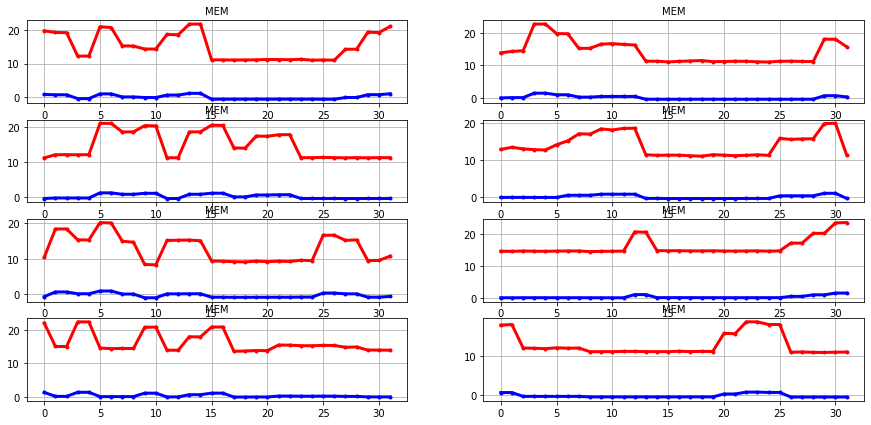

In [38]:
conv_pre = tcnae.predict(X_test)
conv_pre = scaler.inverse_transform(conv_pre.reshape(-1,4)).reshape(-1,32,4)



for i in range(1,9,1):
    
    plt.subplot(4,2,i)
    plt.plot(conv_pre[i+1,:,0],color = 'red',marker='.', label = 'Predict MEM Used',linewidth=3)
    plt.plot(X_test[i+1,:,0],color = 'blue',marker='.', label = 'Real MEM Used',linewidth=3)
    plt.grid()
    plt.title("MEM",fontsize=10)
    
plt.show()

In [44]:
def concate_data(data):

    mem_data = np.concatenate([data[:,:,0],data[:,:,1],data[:,:,2],data[:,:,3]]).reshape(-1,X_WIN,1)
    cpu_data = np.concatenate([data[:,:,4],data[:,:,5],data[:,:,6],data[:,:,7]]).reshape(-1,X_WIN,1)
    return np.concatenate([mem_data,cpu_data],axis=2)

X_train = concate_data(X_train)
X_test = concate_data(X_test)

In [45]:
X_test.shape

(18520, 32, 2)

In [8]:
def model_chk(path):
    
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=path,
    save_weights_only=False,
    monitor='loss',
    mode='min',
    save_best_only=True)
    
    print("checkpoint save in {}".format(path))
    
    return checkpoint

In [17]:
import AE_Conv
import AE_TCN
import importlib
importlib.reload(AE_Conv)
importlib.reload(AE_TCN)

conv_autoencoder = AE_Conv.conv_autoencoder(X_train.shape[1],X_train.shape[2])
tcn_autoencoder = AE_TCN.tcn_autoencoder(X_train.shape[2])

history_convae = conv_autoencoder.fit(
    X_train,
    X_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    verbose=2    
)
save_model(conv_autoencoder,"conv_ae.h5")
history_tcnae = tcn_autoencoder.fit(
    X_train,
    X_train,
    epochs=50,
    batch_size=128,
    verbose=2
)


ModuleNotFoundError: No module named 'AE_Conv'

In [24]:
conv_pre = conv_autoencoder.predict(X_test)
tcn_pre = tcn_autoencoder.predict(X_test)

In [45]:
def concat_pre_data(predict,test):
    
    pre_list = []
    test_list = []
    for i in range(predict.shape[0]):
        pre_list.append(np.concatenate([predict[i],predict[i],predict[i],predict[i]],axis=1)) 
        test_list.append(np.concatenate([test[i],test[i],test[i],test[i]],axis=1)) 
    
    print("predict data shape:{}".format(np.array(pre_list).shape))
    print("test data shape:{}".format(np.array(test_list).shape))

    x_hat = np.array(pre_list)
    x = np.array(test_list)

    x_hat = scaler.inverse_transform(x_hat.reshape(-1,x_hat.shape[-1]))
    x = scaler.inverse_transform(x.reshape(-1,x.shape[-1]))

    return x_hat,x

x_hat,x = concat_pre_data(tcn_pre,X_test)

print(x_hat.shape)
print(x.shape)


predict data shape:(18520, 32, 8)
test data shape:(18520, 32, 8)
(592640, 8)
(592640, 8)


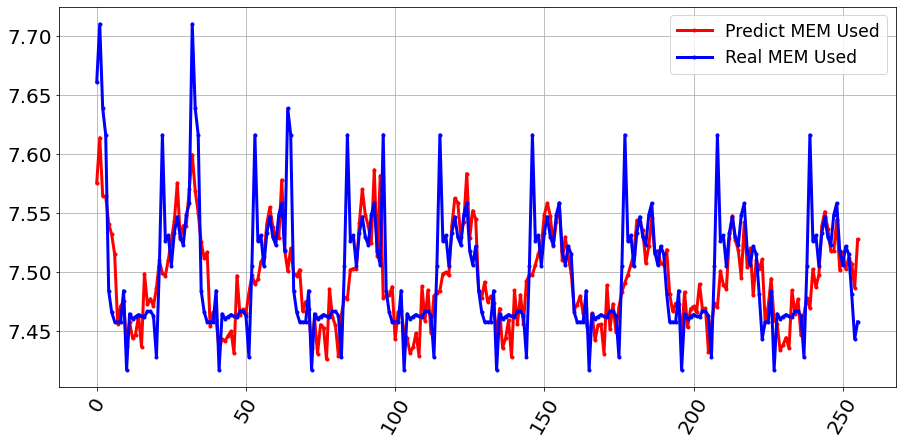

In [46]:
plt.plot(x_hat[:,0].flatten()[:256],color = 'red',marker='.', label = 'Predict MEM Used',linewidth=3)
plt.plot(x[:,0].flatten()[:256],color = 'blue',marker='.', label = 'Real MEM Used',linewidth=3)
plt.xticks(fontsize=20,rotation=60)
plt.yticks(fontsize=20)
plt.grid()
plt.legend(fontsize='xx-large')
#plt.title('Predicted values and actual values on test data',fontsize=20)
plt.show()

In [44]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def cal_score(y_real,y_hat,model_name):
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import mean_absolute_error
    import math

    MAEScore = mean_absolute_error(y_real,y_hat)
    RMSEScore = math.sqrt(mean_squared_error(y_real,y_hat))
    MAPEScore = mean_absolute_percentage_error(y_real,y_hat)
        
    print("Model,MAE,RMSE,MAPE")
    print("{},{},{},{}".format(model_name,round(MAEScore,3),round(RMSEScore,3),round(MAPEScore,3)))
    
    
    return round(MAEScore,3),round(RMSEScore,3),round(MAPEScore,3)

MAE,RMSE,MAPE = cal_score(x,x_hat,"Conv")
MAE,RMSE,MAPE = cal_score(x,x_hat,"TCN")

Conv
MAE:0.15
RMSE:0.527
MAPE:4.775


In [49]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def cal_score(y_real,y_hat):
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import mean_absolute_error
    import math

    MAEScore = mean_absolute_error(y_real,y_hat)
    RMSEScore = math.sqrt(mean_squared_error(y_real,y_hat))
    MAPEScore = mean_absolute_percentage_error(y_real,y_hat)

    print("Model,MAE,RMSE,MAPE")
    print("TCN,{},{},{}".format(round(MAEScore,3),round(RMSEScore,3),round(MAPEScore,3)))
    
    return round(MAEScore,3),round(RMSEScore,3),round(MAPEScore,3)

MAE,RMSE,MAPE = cal_score(x,x_hat)




Model,MAE,RMSE,MAPE
TCN,0.086,0.253,3.448


In [35]:
model.save("SIMPLE_AE.h5")

In [66]:
import AE_VAE
importlib.reload(AE_VAE)

encoder,decoder,vae = AE_VAE.build_VAE(X_train.shape[1],X_train.shape[2],2)
vae.fit(X_train, epochs=50, batch_size=128)

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 32, 8)]      0                                            
__________________________________________________________________________________________________
conv1d_34 (Conv1D)              (None, 16, 32)       800         input_17[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_16 (MaxPooling1D) (None, 8, 32)        0           conv1d_34[0][0]                  
__________________________________________________________________________________________________
conv1d_35 (Conv1D)              (None, 4, 16)        1552        max_pooling1d_16[0][0]           
____________________________________________________________________________________________

ValueError: in user code:

    C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\tensorflow\python\keras\engine\training.py:855 train_function  *
        return step_function(self, iterator)
    C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\tensorflow\python\keras\engine\training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\tensorflow\python\keras\engine\training.py:838 run_step  **
        outputs = model.train_step(data)
    e:\Server_mantain\Spark_test\AE_VAE.py:44 train_step
        reconstruction = self.decoder(z)
    C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1030 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\tensorflow\python\keras\engine\functional.py:420 call
        return self._run_internal_graph(
    C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\tensorflow\python\keras\engine\functional.py:556 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:251 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer conv1d_37 is incompatible with the layer: expected axis -1 of input shape to have value 1 but received input with shape (None, None, 2)


## Run if new training proccess

In [4]:
import os
data_root_path = "E:\Server_mantain\Spark_test\dataset\Zabbix_monitor_SB\concate_with_disk"
data5v_path = os.path.join(data_root_path,"predict_data5V.csv")
data6v_path = os.path.join(data_root_path,"predict_data6V.csv")
data5v = read_data(data5v_path,fill_zero=True)
data6v = read_data(data6v_path,fill_zero=True)

host                   0
CPU utilization (%)    0
Memory used  (%)       1
dtype: int64
host                   0
CPU utilization (%)    0
Memory used  (%)       0
dtype: int64
                                host  CPU utilization (%)  Memory used  (%)
dt                                                                         
2021-06-22 18:41:00  TWKHH01OPTIPW5V              19.8383            0.0000
2021-06-22 18:44:00  TWKHH01OPTIPW5V              18.7174           18.9454
2021-06-22 18:47:00  TWKHH01OPTIPW5V               1.8868           21.0194
2021-06-22 18:50:00  TWKHH01OPTIPW5V              11.0442           17.0870
2021-06-22 18:53:00  TWKHH01OPTIPW5V               2.0538           13.7514
host                   0
CPU utilization (%)    0
Memory used  (%)       0
dtype: int64
host                   0
CPU utilization (%)    0
Memory used  (%)       0
dtype: int64
                                host  CPU utilization (%)  Memory used  (%)
dt                                      

In [7]:
data_list = []

lag = 1
for i in range(0,data5v.shape[0]-lag,lag):
    data_list.append(data5v[i:i+100])




                                host  CPU utilization (%)  Memory used  (%)
dt                                                                         
2021-06-22 18:41:00  TWKHH01OPTIPW5V              19.8383            0.0000
2021-06-22 18:44:00  TWKHH01OPTIPW5V              18.7174           18.9454
2021-06-22 18:47:00  TWKHH01OPTIPW5V               1.8868           21.0194
2021-06-22 18:50:00  TWKHH01OPTIPW5V              11.0442           17.0870
2021-06-22 18:53:00  TWKHH01OPTIPW5V               2.0538           13.7514
...                              ...                  ...               ...
2021-06-22 23:26:00  TWKHH01OPTIPW5V               1.9385           13.6381
2021-06-22 23:29:00  TWKHH01OPTIPW5V               2.3541           13.6668
2021-06-22 23:32:00  TWKHH01OPTIPW5V               1.9646           13.6491
2021-06-22 23:35:00  TWKHH01OPTIPW5V               2.4252           13.6775
2021-06-22 23:38:00  TWKHH01OPTIPW5V              15.0959           13.6250

[100 rows x